# Importamos librerías

In [1]:
import tensorflow as tf
import pathlib
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import keras

In [2]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.initializers import HeNormal
from keras.regularizers import l1, l2

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

# Importamos los datos

In [4]:
path = '../../../Base de datos/Trayectorias 100 eval'

## Datos de entrenamiento

### Datos

In [5]:
varftrain = np.load(path + '/varftrain.npy')

In [6]:
np.shape(varftrain)

(7000, 10, 2, 100)

### Coeficientes

In [7]:
coefvarftrain = np.load(path + '/coefvarftrain.npy')

In [8]:
np.shape(coefvarftrain)

(7000, 7)

## Datos de prueba

### Datos

In [9]:
varftest = np.load(path + '/varftest.npy')

In [10]:
np.shape(varftest)

(1000, 10, 2, 100)

### Coeficientes

In [11]:
coefvarftest = np.load(path + '/coefvarftest.npy')

In [12]:
np.shape(coefvarftest)

(1000, 7)

## Datos de validación

### Datos

In [13]:
varfval = np.load(path + '/varfval.npy')

In [14]:
np.shape(varfval)

(2000, 10, 2, 100)

### Coeficienes

In [15]:
coefvarfval = np.load(path + '/coefvarfval.npy')

In [16]:
np.shape(coefvarfval)

(2000, 7)

# Unimos coeficientes con los datos

In [17]:
train_dataset = tf.data.Dataset.from_tensor_slices((varftrain, coefvarftrain))
test_dataset = tf.data.Dataset.from_tensor_slices((varftest, coefvarftest))
val_dataset = tf.data.Dataset.from_tensor_slices((varfval, coefvarfval))

In [18]:
train_dataset

<TensorSliceDataset element_spec=(TensorSpec(shape=(10, 2, 100), dtype=tf.float64, name=None), TensorSpec(shape=(7,), dtype=tf.int32, name=None))>

# Mezclar y procesar por lotes los conjuntos de datos

In [19]:
BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 100

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.batch(BATCH_SIZE)

# Creación del modelo

In [20]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [21]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(10,2,100)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(25, activation='tanh',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dense(50, activation='relu',kernel_initializer=HeNormal(), kernel_regularizer=l1(0.001)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(7, activation=custom_activation)
])

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2000)              0         
                                                                 
 batch_normalization (BatchN  (None, 2000)             8000      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 100)               200100    
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 25)                1275      
                                                                 
 dense_3 (Dense)             (None, 50)                1300      
                                                        

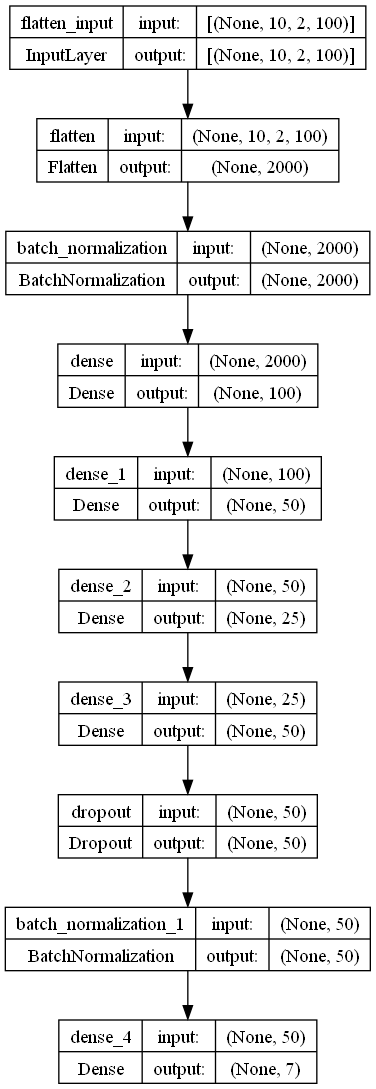

In [23]:
keras.utils.plot_model(model,show_shapes=True)

# Entrenamos el modelo

In [24]:
from keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001,clipvalue=100.0)

In [25]:
def total_mae_loss(y_true, y_pred):
    total_loss = 0
    num_parameters = 7
    for i in range(num_parameters):
        total_loss += tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])
    tf.print(y_true, summarize = -1)
    tf.print(y_pred, summarize = -1)
    return total_loss / num_parameters

In [26]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [27]:
model.compile(optimizer=optimizer,
              loss= 'mean_squared_error',
              metrics=metrics)

In [28]:
def scheduler(epoch, lr):
  if epoch < 400:
    return lr
  else:
    return -1.65e-6*epoch +  0.00166

In [29]:
val_epochs = 1000

early_stop = tf.keras.callbacks.EarlyStopping( monitor = 'val_loss', patience = 1000,verbose = 1, 
                                              restore_best_weights = True)

reduce_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)
history = model.fit(train_dataset, validation_data=val_dataset, epochs= val_epochs, callbacks=[reduce_lr, early_stop])

Epoch 1/1000
70/70 [==============================] - 1s 6ms/step - loss: 15.8204 - a_1: 2.9660 - a_2: 2.9833 - b_1: 2.7700 - b_2: 2.7545 - d_1: 1.7745 - d_2: 1.7329 - n: 2.4988 - mean_metric: 0.5774 - val_loss: 14.2742 - val_a_1: 2.7900 - val_a_2: 2.7315 - val_b_1: 2.6935 - val_b_2: 2.8392 - val_d_1: 2.0519 - val_d_2: 1.8995 - val_n: 1.8490 - val_mean_metric: 0.5591 - lr: 0.0010
Epoch 2/1000
70/70 [==============================] - 0s 4ms/step - loss: 13.4671 - a_1: 2.8695 - a_2: 2.8616 - b_1: 2.5926 - b_2: 2.5573 - d_1: 1.4951 - d_2: 1.4697 - n: 1.9294 - mean_metric: 0.5209 - val_loss: 11.8852 - val_a_1: 2.7056 - val_a_2: 2.6710 - val_b_1: 2.5237 - val_b_2: 2.4087 - val_d_1: 1.5806 - val_d_2: 1.3601 - val_n: 1.6194 - val_mean_metric: 0.4933 - lr: 0.0010
Epoch 3/1000
70/70 [==============================] - 0s 4ms/step - loss: 12.0449 - a_1: 2.8137 - a_2: 2.7270 - b_1: 2.5317 - b_2: 2.4887 - d_1: 1.3450 - d_2: 1.3307 - n: 1.7440 - mean_metric: 0.4946 - val_loss: 10.6985 - val_a_1: 2.6

70/70 [==============================] - 0s 3ms/step - loss: 6.4160 - a_1: 2.5494 - a_2: 2.5104 - b_1: 1.9159 - b_2: 1.8867 - d_1: 0.8142 - d_2: 0.8384 - n: 1.4643 - mean_metric: 0.3955 - val_loss: 6.5350 - val_a_1: 2.4634 - val_a_2: 2.5307 - val_b_1: 1.9628 - val_b_2: 2.1476 - val_d_1: 0.7149 - val_d_2: 0.8690 - val_n: 1.4667 - val_mean_metric: 0.4032 - lr: 0.0010
Epoch 23/1000
70/70 [==============================] - 0s 3ms/step - loss: 6.3853 - a_1: 2.5388 - a_2: 2.5093 - b_1: 1.9331 - b_2: 1.8545 - d_1: 0.8102 - d_2: 0.8381 - n: 1.4583 - mean_metric: 0.3943 - val_loss: 6.0570 - val_a_1: 2.4575 - val_a_2: 2.4806 - val_b_1: 1.8110 - val_b_2: 1.8617 - val_d_1: 0.8326 - val_d_2: 0.7306 - val_n: 1.4602 - val_mean_metric: 0.3860 - lr: 0.0010
Epoch 24/1000
70/70 [==============================] - 0s 3ms/step - loss: 6.3506 - a_1: 2.5294 - a_2: 2.5035 - b_1: 1.9302 - b_2: 1.8742 - d_1: 0.8036 - d_2: 0.8219 - n: 1.4588 - mean_metric: 0.3936 - val_loss: 6.4192 - val_a_1: 2.5016 - val_a_2: 2.

70/70 [==============================] - 0s 3ms/step - loss: 5.7110 - a_1: 2.5270 - a_2: 2.4872 - b_1: 1.7823 - b_2: 1.7341 - d_1: 0.7720 - d_2: 0.7580 - n: 1.4329 - mean_metric: 0.3794 - val_loss: 5.3961 - val_a_1: 2.4395 - val_a_2: 2.4409 - val_b_1: 1.7975 - val_b_2: 1.7161 - val_d_1: 0.5974 - val_d_2: 0.5597 - val_n: 1.4543 - val_mean_metric: 0.3651 - lr: 0.0010
Epoch 44/1000
70/70 [==============================] - 0s 3ms/step - loss: 5.5939 - a_1: 2.5152 - a_2: 2.4761 - b_1: 1.7692 - b_2: 1.7280 - d_1: 0.6957 - d_2: 0.7368 - n: 1.4393 - mean_metric: 0.3749 - val_loss: 5.2958 - val_a_1: 2.3953 - val_a_2: 2.4383 - val_b_1: 1.6048 - val_b_2: 1.7526 - val_d_1: 0.7391 - val_d_2: 0.5360 - val_n: 1.4468 - val_mean_metric: 0.3620 - lr: 0.0010
Epoch 45/1000
70/70 [==============================] - 0s 4ms/step - loss: 5.5930 - a_1: 2.5116 - a_2: 2.4924 - b_1: 1.7497 - b_2: 1.7486 - d_1: 0.7336 - d_2: 0.7404 - n: 1.4344 - mean_metric: 0.3767 - val_loss: 5.2495 - val_a_1: 2.4054 - val_a_2: 2.

70/70 [==============================] - 0s 4ms/step - loss: 5.2080 - a_1: 2.5048 - a_2: 2.4736 - b_1: 1.6811 - b_2: 1.6747 - d_1: 0.6810 - d_2: 0.7253 - n: 1.4314 - mean_metric: 0.3687 - val_loss: 4.7691 - val_a_1: 2.3965 - val_a_2: 2.4224 - val_b_1: 1.5592 - val_b_2: 1.5738 - val_d_1: 0.5626 - val_d_2: 0.5265 - val_n: 1.4468 - val_mean_metric: 0.3479 - lr: 0.0010
Epoch 65/1000
70/70 [==============================] - 0s 4ms/step - loss: 5.0809 - a_1: 2.4896 - a_2: 2.4671 - b_1: 1.6276 - b_2: 1.6470 - d_1: 0.6727 - d_2: 0.7076 - n: 1.4279 - mean_metric: 0.3644 - val_loss: 4.7211 - val_a_1: 2.3954 - val_a_2: 2.4477 - val_b_1: 1.5642 - val_b_2: 1.5217 - val_d_1: 0.5362 - val_d_2: 0.6202 - val_n: 1.4390 - val_mean_metric: 0.3492 - lr: 0.0010
Epoch 66/1000
70/70 [==============================] - 0s 3ms/step - loss: 5.1255 - a_1: 2.4912 - a_2: 2.4578 - b_1: 1.6925 - b_2: 1.6342 - d_1: 0.6956 - d_2: 0.6988 - n: 1.4290 - mean_metric: 0.3664 - val_loss: 4.8690 - val_a_1: 2.4002 - val_a_2: 2.

70/70 [==============================] - 0s 4ms/step - loss: 4.8377 - a_1: 2.4877 - a_2: 2.4600 - b_1: 1.5860 - b_2: 1.5565 - d_1: 0.6570 - d_2: 0.6808 - n: 1.4324 - mean_metric: 0.3586 - val_loss: 4.4972 - val_a_1: 2.3872 - val_a_2: 2.4457 - val_b_1: 1.4295 - val_b_2: 1.4569 - val_d_1: 0.5048 - val_d_2: 0.4882 - val_n: 1.4343 - val_mean_metric: 0.3367 - lr: 0.0010
Epoch 86/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.8551 - a_1: 2.4746 - a_2: 2.4664 - b_1: 1.5889 - b_2: 1.5618 - d_1: 0.6644 - d_2: 0.6793 - n: 1.4286 - mean_metric: 0.3586 - val_loss: 4.5609 - val_a_1: 2.4111 - val_a_2: 2.4428 - val_b_1: 1.4941 - val_b_2: 1.4347 - val_d_1: 0.6040 - val_d_2: 0.5065 - val_n: 1.4383 - val_mean_metric: 0.3428 - lr: 0.0010
Epoch 87/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.7931 - a_1: 2.4743 - a_2: 2.4532 - b_1: 1.5672 - b_2: 1.5480 - d_1: 0.6226 - d_2: 0.6776 - n: 1.4260 - mean_metric: 0.3554 - val_loss: 4.4506 - val_a_1: 2.3847 - val_a_2: 2.

70/70 [==============================] - 0s 4ms/step - loss: 4.6239 - a_1: 2.4724 - a_2: 2.4259 - b_1: 1.4999 - b_2: 1.4923 - d_1: 0.6253 - d_2: 0.6431 - n: 1.4160 - mean_metric: 0.3490 - val_loss: 4.3503 - val_a_1: 2.3840 - val_a_2: 2.4240 - val_b_1: 1.3950 - val_b_2: 1.3431 - val_d_1: 0.5665 - val_d_2: 0.5348 - val_n: 1.4342 - val_mean_metric: 0.3345 - lr: 0.0010
Epoch 107/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.5875 - a_1: 2.4621 - a_2: 2.4337 - b_1: 1.4691 - b_2: 1.4671 - d_1: 0.6326 - d_2: 0.6416 - n: 1.4147 - mean_metric: 0.3472 - val_loss: 4.5648 - val_a_1: 2.4127 - val_a_2: 2.4160 - val_b_1: 1.5538 - val_b_2: 1.4245 - val_d_1: 0.7598 - val_d_2: 0.4547 - val_n: 1.4312 - val_mean_metric: 0.3468 - lr: 0.0010
Epoch 108/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.5835 - a_1: 2.4584 - a_2: 2.4272 - b_1: 1.4569 - b_2: 1.4831 - d_1: 0.6368 - d_2: 0.6393 - n: 1.4207 - mean_metric: 0.3473 - val_loss: 4.4058 - val_a_1: 2.3812 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.4694 - a_1: 2.4496 - a_2: 2.4166 - b_1: 1.4795 - b_2: 1.3996 - d_1: 0.6301 - d_2: 0.6228 - n: 1.4065 - mean_metric: 0.3435 - val_loss: 4.2212 - val_a_1: 2.3465 - val_a_2: 2.4041 - val_b_1: 1.4040 - val_b_2: 1.3264 - val_d_1: 0.4842 - val_d_2: 0.4551 - val_n: 1.4199 - val_mean_metric: 0.3264 - lr: 0.0010
Epoch 128/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.4777 - a_1: 2.4348 - a_2: 2.4258 - b_1: 1.4188 - b_2: 1.4435 - d_1: 0.6090 - d_2: 0.6445 - n: 1.4069 - mean_metric: 0.3427 - val_loss: 4.3170 - val_a_1: 2.3427 - val_a_2: 2.4156 - val_b_1: 1.5114 - val_b_2: 1.3626 - val_d_1: 0.4728 - val_d_2: 0.4783 - val_n: 1.4214 - val_mean_metric: 0.3319 - lr: 0.0010
Epoch 129/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.4763 - a_1: 2.4438 - a_2: 2.4254 - b_1: 1.4320 - b_2: 1.4189 - d_1: 0.6156 - d_2: 0.6353 - n: 1.4011 - mean_metric: 0.3423 - val_loss: 4.3262 - val_a_1: 2.3628 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.4249 - a_1: 2.4216 - a_2: 2.4065 - b_1: 1.4057 - b_2: 1.4440 - d_1: 0.6118 - d_2: 0.6272 - n: 1.4007 - mean_metric: 0.3406 - val_loss: 4.0833 - val_a_1: 2.3467 - val_a_2: 2.3475 - val_b_1: 1.4234 - val_b_2: 1.2747 - val_d_1: 0.5007 - val_d_2: 0.4631 - val_n: 1.4068 - val_mean_metric: 0.3239 - lr: 0.0010
Epoch 149/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.3539 - a_1: 2.4220 - a_2: 2.4011 - b_1: 1.3968 - b_2: 1.3820 - d_1: 0.5980 - d_2: 0.6124 - n: 1.3990 - mean_metric: 0.3370 - val_loss: 4.0462 - val_a_1: 2.3269 - val_a_2: 2.3751 - val_b_1: 1.2870 - val_b_2: 1.2694 - val_d_1: 0.4260 - val_d_2: 0.4220 - val_n: 1.4032 - val_mean_metric: 0.3155 - lr: 0.0010
Epoch 150/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.3743 - a_1: 2.4247 - a_2: 2.4127 - b_1: 1.4133 - b_2: 1.3905 - d_1: 0.6152 - d_2: 0.6331 - n: 1.4048 - mean_metric: 0.3398 - val_loss: 4.0542 - val_a_1: 2.3312 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.3750 - a_1: 2.4148 - a_2: 2.4276 - b_1: 1.3895 - b_2: 1.4151 - d_1: 0.6044 - d_2: 0.6234 - n: 1.3871 - mean_metric: 0.3387 - val_loss: 4.0314 - val_a_1: 2.3234 - val_a_2: 2.3492 - val_b_1: 1.3502 - val_b_2: 1.2564 - val_d_1: 0.5357 - val_d_2: 0.3953 - val_n: 1.3889 - val_mean_metric: 0.3184 - lr: 0.0010
Epoch 170/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.3023 - a_1: 2.4019 - a_2: 2.4184 - b_1: 1.3625 - b_2: 1.3750 - d_1: 0.6042 - d_2: 0.6128 - n: 1.3937 - mean_metric: 0.3356 - val_loss: 4.0208 - val_a_1: 2.3297 - val_a_2: 2.3690 - val_b_1: 1.3049 - val_b_2: 1.2532 - val_d_1: 0.5139 - val_d_2: 0.4242 - val_n: 1.3943 - val_mean_metric: 0.3181 - lr: 0.0010
Epoch 171/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.3264 - a_1: 2.4192 - a_2: 2.3920 - b_1: 1.3926 - b_2: 1.3738 - d_1: 0.6259 - d_2: 0.6221 - n: 1.3946 - mean_metric: 0.3374 - val_loss: 4.1068 - val_a_1: 2.3375 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.2830 - a_1: 2.4028 - a_2: 2.3956 - b_1: 1.3834 - b_2: 1.3539 - d_1: 0.5997 - d_2: 0.6240 - n: 1.3867 - mean_metric: 0.3349 - val_loss: 4.0054 - val_a_1: 2.3123 - val_a_2: 2.3782 - val_b_1: 1.3032 - val_b_2: 1.2577 - val_d_1: 0.5567 - val_d_2: 0.3786 - val_n: 1.3916 - val_mean_metric: 0.3178 - lr: 0.0010
Epoch 191/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.2553 - a_1: 2.3929 - a_2: 2.3890 - b_1: 1.3839 - b_2: 1.3511 - d_1: 0.5952 - d_2: 0.6015 - n: 1.3869 - mean_metric: 0.3333 - val_loss: 3.9554 - val_a_1: 2.3468 - val_a_2: 2.3356 - val_b_1: 1.3131 - val_b_2: 1.2046 - val_d_1: 0.4416 - val_d_2: 0.3938 - val_n: 1.3900 - val_mean_metric: 0.3127 - lr: 0.0010
Epoch 192/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.2692 - a_1: 2.4122 - a_2: 2.3845 - b_1: 1.3776 - b_2: 1.3612 - d_1: 0.6052 - d_2: 0.6008 - n: 1.3856 - mean_metric: 0.3343 - val_loss: 3.9584 - val_a_1: 2.3081 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.2126 - a_1: 2.3912 - a_2: 2.4066 - b_1: 1.3409 - b_2: 1.3127 - d_1: 0.5880 - d_2: 0.6145 - n: 1.3852 - mean_metric: 0.3314 - val_loss: 4.0082 - val_a_1: 2.3090 - val_a_2: 2.3700 - val_b_1: 1.3082 - val_b_2: 1.2613 - val_d_1: 0.5071 - val_d_2: 0.4402 - val_n: 1.3804 - val_mean_metric: 0.3177 - lr: 0.0010
Epoch 212/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1784 - a_1: 2.3848 - a_2: 2.3785 - b_1: 1.3465 - b_2: 1.3335 - d_1: 0.5889 - d_2: 0.5948 - n: 1.3848 - mean_metric: 0.3305 - val_loss: 4.1587 - val_a_1: 2.3222 - val_a_2: 2.3575 - val_b_1: 1.5475 - val_b_2: 1.2521 - val_d_1: 0.5958 - val_d_2: 0.4687 - val_n: 1.3926 - val_mean_metric: 0.3296 - lr: 0.0010
Epoch 213/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.2092 - a_1: 2.3781 - a_2: 2.3850 - b_1: 1.3570 - b_2: 1.3569 - d_1: 0.5804 - d_2: 0.6182 - n: 1.3801 - mean_metric: 0.3318 - val_loss: 3.9420 - val_a_1: 2.3109 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.2273 - a_1: 2.3951 - a_2: 2.3742 - b_1: 1.3674 - b_2: 1.3521 - d_1: 0.6116 - d_2: 0.5918 - n: 1.3834 - mean_metric: 0.3326 - val_loss: 3.9463 - val_a_1: 2.3091 - val_a_2: 2.3314 - val_b_1: 1.3401 - val_b_2: 1.2233 - val_d_1: 0.4957 - val_d_2: 0.3930 - val_n: 1.3723 - val_mean_metric: 0.3140 - lr: 0.0010
Epoch 233/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1861 - a_1: 2.3780 - a_2: 2.3678 - b_1: 1.3424 - b_2: 1.3300 - d_1: 0.6027 - d_2: 0.6094 - n: 1.3841 - mean_metric: 0.3305 - val_loss: 3.9660 - val_a_1: 2.2936 - val_a_2: 2.3375 - val_b_1: 1.3075 - val_b_2: 1.3881 - val_d_1: 0.4470 - val_d_2: 0.4271 - val_n: 1.3863 - val_mean_metric: 0.3180 - lr: 0.0010
Epoch 234/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.2346 - a_1: 2.3998 - a_2: 2.3885 - b_1: 1.3585 - b_2: 1.3636 - d_1: 0.5849 - d_2: 0.6001 - n: 1.3798 - mean_metric: 0.3326 - val_loss: 4.0954 - val_a_1: 2.2985 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.1459 - a_1: 2.3845 - a_2: 2.3700 - b_1: 1.3164 - b_2: 1.3188 - d_1: 0.6022 - d_2: 0.5861 - n: 1.3760 - mean_metric: 0.3286 - val_loss: 3.8724 - val_a_1: 2.2875 - val_a_2: 2.3476 - val_b_1: 1.2788 - val_b_2: 1.2222 - val_d_1: 0.4178 - val_d_2: 0.3813 - val_n: 1.3680 - val_mean_metric: 0.3086 - lr: 0.0010
Epoch 254/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1433 - a_1: 2.3766 - a_2: 2.3696 - b_1: 1.3052 - b_2: 1.3340 - d_1: 0.5983 - d_2: 0.5886 - n: 1.3765 - mean_metric: 0.3284 - val_loss: 3.8304 - val_a_1: 2.2847 - val_a_2: 2.3300 - val_b_1: 1.2651 - val_b_2: 1.2186 - val_d_1: 0.5042 - val_d_2: 0.4045 - val_n: 1.3751 - val_mean_metric: 0.3112 - lr: 0.0010
Epoch 255/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1098 - a_1: 2.3785 - a_2: 2.3663 - b_1: 1.3222 - b_2: 1.2899 - d_1: 0.6063 - d_2: 0.5720 - n: 1.3811 - mean_metric: 0.3273 - val_loss: 3.8721 - val_a_1: 2.3055 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.1483 - a_1: 2.3819 - a_2: 2.3740 - b_1: 1.3435 - b_2: 1.3094 - d_1: 0.5904 - d_2: 0.5920 - n: 1.3748 - mean_metric: 0.3290 - val_loss: 3.9052 - val_a_1: 2.3046 - val_a_2: 2.3306 - val_b_1: 1.2903 - val_b_2: 1.2242 - val_d_1: 0.4440 - val_d_2: 0.3955 - val_n: 1.3669 - val_mean_metric: 0.3104 - lr: 0.0010
Epoch 275/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.0869 - a_1: 2.3711 - a_2: 2.3487 - b_1: 1.2998 - b_2: 1.3149 - d_1: 0.5802 - d_2: 0.5851 - n: 1.3729 - mean_metric: 0.3259 - val_loss: 3.8436 - val_a_1: 2.3015 - val_a_2: 2.3260 - val_b_1: 1.2763 - val_b_2: 1.2210 - val_d_1: 0.3899 - val_d_2: 0.4305 - val_n: 1.3728 - val_mean_metric: 0.3091 - lr: 0.0010
Epoch 276/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1216 - a_1: 2.3608 - a_2: 2.3633 - b_1: 1.3267 - b_2: 1.3122 - d_1: 0.6000 - d_2: 0.5839 - n: 1.3744 - mean_metric: 0.3274 - val_loss: 3.9917 - val_a_1: 2.3021 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.0567 - a_1: 2.3577 - a_2: 2.3396 - b_1: 1.2978 - b_2: 1.3103 - d_1: 0.5746 - d_2: 0.5681 - n: 1.3665 - mean_metric: 0.3240 - val_loss: 3.9309 - val_a_1: 2.3062 - val_a_2: 2.3112 - val_b_1: 1.4216 - val_b_2: 1.2319 - val_d_1: 0.5247 - val_d_2: 0.3859 - val_n: 1.3801 - val_mean_metric: 0.3172 - lr: 0.0010
Epoch 296/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1434 - a_1: 2.3981 - a_2: 2.3528 - b_1: 1.3206 - b_2: 1.3312 - d_1: 0.5828 - d_2: 0.5886 - n: 1.3737 - mean_metric: 0.3283 - val_loss: 3.9293 - val_a_1: 2.3011 - val_a_2: 2.3631 - val_b_1: 1.3293 - val_b_2: 1.2053 - val_d_1: 0.4517 - val_d_2: 0.3968 - val_n: 1.3627 - val_mean_metric: 0.3122 - lr: 0.0010
Epoch 297/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1296 - a_1: 2.3830 - a_2: 2.3559 - b_1: 1.3456 - b_2: 1.3089 - d_1: 0.5957 - d_2: 0.5956 - n: 1.3713 - mean_metric: 0.3286 - val_loss: 3.8382 - val_a_1: 2.2996 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.0983 - a_1: 2.3874 - a_2: 2.3633 - b_1: 1.3268 - b_2: 1.2845 - d_1: 0.5931 - d_2: 0.5790 - n: 1.3746 - mean_metric: 0.3271 - val_loss: 3.8658 - val_a_1: 2.2978 - val_a_2: 2.3231 - val_b_1: 1.3017 - val_b_2: 1.2032 - val_d_1: 0.4644 - val_d_2: 0.3863 - val_n: 1.3582 - val_mean_metric: 0.3097 - lr: 0.0010
Epoch 317/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.1307 - a_1: 2.3906 - a_2: 2.3501 - b_1: 1.3418 - b_2: 1.3261 - d_1: 0.5926 - d_2: 0.5857 - n: 1.3640 - mean_metric: 0.3285 - val_loss: 3.9761 - val_a_1: 2.2887 - val_a_2: 2.3096 - val_b_1: 1.5663 - val_b_2: 1.1971 - val_d_1: 0.4441 - val_d_2: 0.4160 - val_n: 1.3641 - val_mean_metric: 0.3180 - lr: 0.0010
Epoch 318/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.0563 - a_1: 2.3646 - a_2: 2.3491 - b_1: 1.3127 - b_2: 1.2740 - d_1: 0.5805 - d_2: 0.5840 - n: 1.3681 - mean_metric: 0.3245 - val_loss: 3.7968 - val_a_1: 2.3170 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.0272 - a_1: 2.3558 - a_2: 2.3547 - b_1: 1.3041 - b_2: 1.2655 - d_1: 0.5758 - d_2: 0.5616 - n: 1.3600 - mean_metric: 0.3227 - val_loss: 3.8208 - val_a_1: 2.2875 - val_a_2: 2.3106 - val_b_1: 1.3321 - val_b_2: 1.1942 - val_d_1: 0.4765 - val_d_2: 0.4094 - val_n: 1.3654 - val_mean_metric: 0.3110 - lr: 0.0010
Epoch 338/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.0572 - a_1: 2.3565 - a_2: 2.3512 - b_1: 1.2905 - b_2: 1.3127 - d_1: 0.5812 - d_2: 0.5930 - n: 1.3686 - mean_metric: 0.3253 - val_loss: 3.9805 - val_a_1: 2.2921 - val_a_2: 2.3458 - val_b_1: 1.4313 - val_b_2: 1.2387 - val_d_1: 0.5852 - val_d_2: 0.3827 - val_n: 1.3660 - val_mean_metric: 0.3199 - lr: 0.0010
Epoch 339/1000
70/70 [==============================] - 0s 3ms/step - loss: 4.0037 - a_1: 2.3519 - a_2: 2.3175 - b_1: 1.3047 - b_2: 1.2695 - d_1: 0.5674 - d_2: 0.5545 - n: 1.3594 - mean_metric: 0.3211 - val_loss: 3.8265 - val_a_1: 2.2817 - val_a_2: 

70/70 [==============================] - 0s 3ms/step - loss: 4.0153 - a_1: 2.3586 - a_2: 2.3513 - b_1: 1.2784 - b_2: 1.2607 - d_1: 0.5741 - d_2: 0.5779 - n: 1.3652 - mean_metric: 0.3224 - val_loss: 3.8784 - val_a_1: 2.2905 - val_a_2: 2.3155 - val_b_1: 1.3505 - val_b_2: 1.2609 - val_d_1: 0.4883 - val_d_2: 0.4192 - val_n: 1.3710 - val_mean_metric: 0.3150 - lr: 0.0010
Epoch 359/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.0625 - a_1: 2.3602 - a_2: 2.3495 - b_1: 1.3081 - b_2: 1.2938 - d_1: 0.5819 - d_2: 0.5836 - n: 1.3723 - mean_metric: 0.3251 - val_loss: 4.1279 - val_a_1: 2.3129 - val_a_2: 2.3530 - val_b_1: 1.6102 - val_b_2: 1.2293 - val_d_1: 0.4837 - val_d_2: 0.4220 - val_n: 1.3643 - val_mean_metric: 0.3243 - lr: 0.0010
Epoch 360/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.0681 - a_1: 2.3709 - a_2: 2.3481 - b_1: 1.3288 - b_2: 1.2819 - d_1: 0.5678 - d_2: 0.5748 - n: 1.3563 - mean_metric: 0.3244 - val_loss: 3.8124 - val_a_1: 2.2669 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.0185 - a_1: 2.3482 - a_2: 2.3232 - b_1: 1.2892 - b_2: 1.2920 - d_1: 0.5769 - d_2: 0.5882 - n: 1.3634 - mean_metric: 0.3229 - val_loss: 3.7128 - val_a_1: 2.2790 - val_a_2: 2.3073 - val_b_1: 1.1642 - val_b_2: 1.1690 - val_d_1: 0.3954 - val_d_2: 0.3832 - val_n: 1.3463 - val_mean_metric: 0.3000 - lr: 0.0010
Epoch 380/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.0383 - a_1: 2.3677 - a_2: 2.3348 - b_1: 1.3029 - b_2: 1.2750 - d_1: 0.5809 - d_2: 0.5733 - n: 1.3634 - mean_metric: 0.3234 - val_loss: 3.8193 - val_a_1: 2.2774 - val_a_2: 2.3436 - val_b_1: 1.2290 - val_b_2: 1.2420 - val_d_1: 0.3967 - val_d_2: 0.4178 - val_n: 1.3576 - val_mean_metric: 0.3073 - lr: 0.0010
Epoch 381/1000
70/70 [==============================] - 0s 4ms/step - loss: 4.0388 - a_1: 2.3429 - a_2: 2.3418 - b_1: 1.3096 - b_2: 1.2817 - d_1: 0.5805 - d_2: 0.5844 - n: 1.3684 - mean_metric: 0.3239 - val_loss: 3.8166 - val_a_1: 2.3108 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 4.0125 - a_1: 2.3567 - a_2: 2.3266 - b_1: 1.2939 - b_2: 1.2810 - d_1: 0.5735 - d_2: 0.5857 - n: 1.3555 - mean_metric: 0.3225 - val_loss: 3.8581 - val_a_1: 2.2851 - val_a_2: 2.3102 - val_b_1: 1.3491 - val_b_2: 1.2346 - val_d_1: 0.5187 - val_d_2: 0.3808 - val_n: 1.3704 - val_mean_metric: 0.3135 - lr: 0.0010
Epoch 401/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9409 - a_1: 2.3277 - a_2: 2.3176 - b_1: 1.2759 - b_2: 1.2483 - d_1: 0.5665 - d_2: 0.5578 - n: 1.3620 - mean_metric: 0.3187 - val_loss: 3.8252 - val_a_1: 2.2721 - val_a_2: 2.3343 - val_b_1: 1.2765 - val_b_2: 1.2070 - val_d_1: 0.4928 - val_d_2: 0.3508 - val_n: 1.3540 - val_mean_metric: 0.3081 - lr: 0.0010
Epoch 402/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9949 - a_1: 2.3355 - a_2: 2.3439 - b_1: 1.2914 - b_2: 1.2613 - d_1: 0.5705 - d_2: 0.5763 - n: 1.3575 - mean_metric: 0.3214 - val_loss: 3.8389 - val_a_1: 2.2825 - val_a_2: 

70/70 [==============================] - 0s 4ms/step - loss: 3.9602 - a_1: 2.3331 - a_2: 2.3201 - b_1: 1.2795 - b_2: 1.2583 - d_1: 0.5685 - d_2: 0.5810 - n: 1.3545 - mean_metric: 0.3200 - val_loss: 3.7268 - val_a_1: 2.2642 - val_a_2: 2.2913 - val_b_1: 1.1770 - val_b_2: 1.2600 - val_d_1: 0.3774 - val_d_2: 0.3813 - val_n: 1.3581 - val_mean_metric: 0.3022 - lr: 9.6700e-04
Epoch 422/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.9661 - a_1: 2.3338 - a_2: 2.3171 - b_1: 1.2771 - b_2: 1.2686 - d_1: 0.5800 - d_2: 0.5765 - n: 1.3577 - mean_metric: 0.3206 - val_loss: 3.9209 - val_a_1: 2.2883 - val_a_2: 2.3291 - val_b_1: 1.2917 - val_b_2: 1.2658 - val_d_1: 0.6437 - val_d_2: 0.3727 - val_n: 1.3485 - val_mean_metric: 0.3164 - lr: 9.6535e-04
Epoch 423/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9819 - a_1: 2.3458 - a_2: 2.3200 - b_1: 1.2923 - b_2: 1.2753 - d_1: 0.5816 - d_2: 0.5822 - n: 1.3593 - mean_metric: 0.3220 - val_loss: 3.7594 - val_a_1: 2.2793 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.9506 - a_1: 2.3380 - a_2: 2.3163 - b_1: 1.2914 - b_2: 1.2563 - d_1: 0.5750 - d_2: 0.5727 - n: 1.3604 - mean_metric: 0.3206 - val_loss: 3.7267 - val_a_1: 2.2637 - val_a_2: 2.3143 - val_b_1: 1.2062 - val_b_2: 1.1857 - val_d_1: 0.4326 - val_d_2: 0.3745 - val_n: 1.3481 - val_mean_metric: 0.3027 - lr: 9.3235e-04
Epoch 443/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9684 - a_1: 2.3502 - a_2: 2.3187 - b_1: 1.2992 - b_2: 1.2493 - d_1: 0.5890 - d_2: 0.5893 - n: 1.3499 - mean_metric: 0.3216 - val_loss: 3.7812 - val_a_1: 2.2716 - val_a_2: 2.3238 - val_b_1: 1.2170 - val_b_2: 1.1920 - val_d_1: 0.3832 - val_d_2: 0.4194 - val_n: 1.3465 - val_mean_metric: 0.3037 - lr: 9.3070e-04
Epoch 444/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9066 - a_1: 2.3111 - a_2: 2.3082 - b_1: 1.2533 - b_2: 1.2547 - d_1: 0.5585 - d_2: 0.5688 - n: 1.3572 - mean_metric: 0.3173 - val_loss: 3.6758 - val_a_1: 2.2637 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.9607 - a_1: 2.3373 - a_2: 2.3155 - b_1: 1.2894 - b_2: 1.2581 - d_1: 0.5657 - d_2: 0.5917 - n: 1.3526 - mean_metric: 0.3205 - val_loss: 3.8427 - val_a_1: 2.2552 - val_a_2: 2.3320 - val_b_1: 1.3379 - val_b_2: 1.2815 - val_d_1: 0.3707 - val_d_2: 0.3557 - val_n: 1.3459 - val_mean_metric: 0.3078 - lr: 8.9770e-04
Epoch 464/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9006 - a_1: 2.3306 - a_2: 2.3040 - b_1: 1.2531 - b_2: 1.2457 - d_1: 0.5711 - d_2: 0.5693 - n: 1.3531 - mean_metric: 0.3178 - val_loss: 3.7458 - val_a_1: 2.2869 - val_a_2: 2.3078 - val_b_1: 1.2100 - val_b_2: 1.1667 - val_d_1: 0.4488 - val_d_2: 0.3578 - val_n: 1.3459 - val_mean_metric: 0.3027 - lr: 8.9605e-04
Epoch 465/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9384 - a_1: 2.3346 - a_2: 2.3058 - b_1: 1.2792 - b_2: 1.2484 - d_1: 0.5789 - d_2: 0.5657 - n: 1.3599 - mean_metric: 0.3193 - val_loss: 3.8113 - val_a_1: 2.2725 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.9015 - a_1: 2.3231 - a_2: 2.3068 - b_1: 1.2684 - b_2: 1.2512 - d_1: 0.5631 - d_2: 0.5624 - n: 1.3516 - mean_metric: 0.3178 - val_loss: 3.7636 - val_a_1: 2.2552 - val_a_2: 2.3029 - val_b_1: 1.3014 - val_b_2: 1.1602 - val_d_1: 0.4603 - val_d_2: 0.3703 - val_n: 1.3596 - val_mean_metric: 0.3055 - lr: 8.6305e-04
Epoch 485/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9316 - a_1: 2.3254 - a_2: 2.3057 - b_1: 1.2804 - b_2: 1.2624 - d_1: 0.5558 - d_2: 0.5831 - n: 1.3429 - mean_metric: 0.3186 - val_loss: 3.7760 - val_a_1: 2.2833 - val_a_2: 2.3030 - val_b_1: 1.2809 - val_b_2: 1.1846 - val_d_1: 0.4507 - val_d_2: 0.3912 - val_n: 1.3615 - val_mean_metric: 0.3070 - lr: 8.6140e-04
Epoch 486/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9427 - a_1: 2.3382 - a_2: 2.3129 - b_1: 1.2683 - b_2: 1.2633 - d_1: 0.5693 - d_2: 0.5774 - n: 1.3494 - mean_metric: 0.3195 - val_loss: 3.7053 - val_a_1: 2.2874 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.8718 - a_1: 2.3156 - a_2: 2.2916 - b_1: 1.2661 - b_2: 1.2463 - d_1: 0.5517 - d_2: 0.5700 - n: 1.3423 - mean_metric: 0.3163 - val_loss: 3.7871 - val_a_1: 2.2502 - val_a_2: 2.3216 - val_b_1: 1.2317 - val_b_2: 1.2036 - val_d_1: 0.4665 - val_d_2: 0.4297 - val_n: 1.3538 - val_mean_metric: 0.3071 - lr: 8.2840e-04
Epoch 506/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9109 - a_1: 2.3323 - a_2: 2.3067 - b_1: 1.2559 - b_2: 1.2617 - d_1: 0.5674 - d_2: 0.5713 - n: 1.3479 - mean_metric: 0.3183 - val_loss: 3.6880 - val_a_1: 2.2494 - val_a_2: 2.2978 - val_b_1: 1.1508 - val_b_2: 1.1934 - val_d_1: 0.3628 - val_d_2: 0.4338 - val_n: 1.3376 - val_mean_metric: 0.2994 - lr: 8.2675e-04
Epoch 507/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8765 - a_1: 2.3159 - a_2: 2.2908 - b_1: 1.2519 - b_2: 1.2498 - d_1: 0.5675 - d_2: 0.5755 - n: 1.3547 - mean_metric: 0.3171 - val_loss: 3.7092 - val_a_1: 2.2882 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.8670 - a_1: 2.3159 - a_2: 2.3120 - b_1: 1.2495 - b_2: 1.2355 - d_1: 0.5598 - d_2: 0.5854 - n: 1.3433 - mean_metric: 0.3169 - val_loss: 3.7101 - val_a_1: 2.2656 - val_a_2: 2.2941 - val_b_1: 1.1606 - val_b_2: 1.1974 - val_d_1: 0.3816 - val_d_2: 0.3708 - val_n: 1.3356 - val_mean_metric: 0.2987 - lr: 7.9375e-04
Epoch 527/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9121 - a_1: 2.3330 - a_2: 2.3184 - b_1: 1.2646 - b_2: 1.2348 - d_1: 0.5715 - d_2: 0.5688 - n: 1.3509 - mean_metric: 0.3182 - val_loss: 3.7233 - val_a_1: 2.2432 - val_a_2: 2.3237 - val_b_1: 1.1810 - val_b_2: 1.2192 - val_d_1: 0.3779 - val_d_2: 0.3926 - val_n: 1.3501 - val_mean_metric: 0.3015 - lr: 7.9210e-04
Epoch 528/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.9047 - a_1: 2.3233 - a_2: 2.3093 - b_1: 1.2701 - b_2: 1.2455 - d_1: 0.5551 - d_2: 0.5826 - n: 1.3514 - mean_metric: 0.3181 - val_loss: 3.7302 - val_a_1: 2.2530 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.8741 - a_1: 2.3006 - a_2: 2.3012 - b_1: 1.2481 - b_2: 1.2620 - d_1: 0.5613 - d_2: 0.5686 - n: 1.3463 - mean_metric: 0.3165 - val_loss: 3.6680 - val_a_1: 2.2607 - val_a_2: 2.3029 - val_b_1: 1.1373 - val_b_2: 1.1645 - val_d_1: 0.4195 - val_d_2: 0.3646 - val_n: 1.3418 - val_mean_metric: 0.2983 - lr: 7.5910e-04
Epoch 548/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8542 - a_1: 2.3072 - a_2: 2.3009 - b_1: 1.2386 - b_2: 1.2207 - d_1: 0.5576 - d_2: 0.5769 - n: 1.3523 - mean_metric: 0.3154 - val_loss: 3.6665 - val_a_1: 2.2405 - val_a_2: 2.2904 - val_b_1: 1.2308 - val_b_2: 1.1674 - val_d_1: 0.4109 - val_d_2: 0.3380 - val_n: 1.3473 - val_mean_metric: 0.2994 - lr: 7.5745e-04
Epoch 549/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8341 - a_1: 2.3040 - a_2: 2.2964 - b_1: 1.2396 - b_2: 1.2233 - d_1: 0.5624 - d_2: 0.5632 - n: 1.3548 - mean_metric: 0.3150 - val_loss: 3.6764 - val_a_1: 2.2512 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.8569 - a_1: 2.3193 - a_2: 2.2940 - b_1: 1.2380 - b_2: 1.2572 - d_1: 0.5479 - d_2: 0.5749 - n: 1.3548 - mean_metric: 0.3165 - val_loss: 3.6815 - val_a_1: 2.2514 - val_a_2: 2.3099 - val_b_1: 1.1470 - val_b_2: 1.1802 - val_d_1: 0.3642 - val_d_2: 0.3597 - val_n: 1.3392 - val_mean_metric: 0.2969 - lr: 7.2445e-04
Epoch 569/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8379 - a_1: 2.3064 - a_2: 2.3053 - b_1: 1.2344 - b_2: 1.2267 - d_1: 0.5584 - d_2: 0.5699 - n: 1.3455 - mean_metric: 0.3151 - val_loss: 3.7114 - val_a_1: 2.2426 - val_a_2: 2.3008 - val_b_1: 1.2048 - val_b_2: 1.2154 - val_d_1: 0.4292 - val_d_2: 0.3507 - val_n: 1.3444 - val_mean_metric: 0.3015 - lr: 7.2280e-04
Epoch 570/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8401 - a_1: 2.3071 - a_2: 2.2855 - b_1: 1.2490 - b_2: 1.2296 - d_1: 0.5552 - d_2: 0.5673 - n: 1.3540 - mean_metric: 0.3152 - val_loss: 3.6692 - val_a_1: 2.2623 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7965 - a_1: 2.3006 - a_2: 2.2787 - b_1: 1.2267 - b_2: 1.2139 - d_1: 0.5574 - d_2: 0.5469 - n: 1.3415 - mean_metric: 0.3125 - val_loss: 3.6624 - val_a_1: 2.2320 - val_a_2: 2.2985 - val_b_1: 1.1816 - val_b_2: 1.2563 - val_d_1: 0.4024 - val_d_2: 0.3709 - val_n: 1.3543 - val_mean_metric: 0.3017 - lr: 6.8980e-04
Epoch 590/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8286 - a_1: 2.3158 - a_2: 2.2794 - b_1: 1.2303 - b_2: 1.2346 - d_1: 0.5621 - d_2: 0.5559 - n: 1.3472 - mean_metric: 0.3144 - val_loss: 3.6928 - val_a_1: 2.2662 - val_a_2: 2.3040 - val_b_1: 1.1601 - val_b_2: 1.1770 - val_d_1: 0.3735 - val_d_2: 0.3750 - val_n: 1.3386 - val_mean_metric: 0.2984 - lr: 6.8815e-04
Epoch 591/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8232 - a_1: 2.3143 - a_2: 2.2783 - b_1: 1.2491 - b_2: 1.2010 - d_1: 0.5582 - d_2: 0.5660 - n: 1.3458 - mean_metric: 0.3140 - val_loss: 3.6382 - val_a_1: 2.2532 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7852 - a_1: 2.2942 - a_2: 2.2767 - b_1: 1.2358 - b_2: 1.2039 - d_1: 0.5673 - d_2: 0.5583 - n: 1.3465 - mean_metric: 0.3130 - val_loss: 3.6255 - val_a_1: 2.2412 - val_a_2: 2.2985 - val_b_1: 1.1114 - val_b_2: 1.2040 - val_d_1: 0.3730 - val_d_2: 0.3669 - val_n: 1.3322 - val_mean_metric: 0.2962 - lr: 6.5515e-04
Epoch 611/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7853 - a_1: 2.2984 - a_2: 2.2744 - b_1: 1.2310 - b_2: 1.2155 - d_1: 0.5599 - d_2: 0.5552 - n: 1.3380 - mean_metric: 0.3127 - val_loss: 3.6267 - val_a_1: 2.2441 - val_a_2: 2.2951 - val_b_1: 1.1931 - val_b_2: 1.1254 - val_d_1: 0.4031 - val_d_2: 0.3393 - val_n: 1.3376 - val_mean_metric: 0.2965 - lr: 6.5350e-04
Epoch 612/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.8245 - a_1: 2.3086 - a_2: 2.2949 - b_1: 1.2372 - b_2: 1.2278 - d_1: 0.5440 - d_2: 0.5706 - n: 1.3514 - mean_metric: 0.3147 - val_loss: 3.6531 - val_a_1: 2.2620 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7998 - a_1: 2.3013 - a_2: 2.2926 - b_1: 1.2343 - b_2: 1.2068 - d_1: 0.5417 - d_2: 0.5625 - n: 1.3385 - mean_metric: 0.3128 - val_loss: 3.6301 - val_a_1: 2.2162 - val_a_2: 2.3150 - val_b_1: 1.1625 - val_b_2: 1.1400 - val_d_1: 0.3873 - val_d_2: 0.3495 - val_n: 1.3299 - val_mean_metric: 0.2953 - lr: 6.2050e-04
Epoch 632/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7451 - a_1: 2.2852 - a_2: 2.2692 - b_1: 1.2273 - b_2: 1.2035 - d_1: 0.5462 - d_2: 0.5510 - n: 1.3389 - mean_metric: 0.3109 - val_loss: 3.6096 - val_a_1: 2.2333 - val_a_2: 2.3035 - val_b_1: 1.1060 - val_b_2: 1.1717 - val_d_1: 0.3473 - val_d_2: 0.3478 - val_n: 1.3275 - val_mean_metric: 0.2932 - lr: 6.1885e-04
Epoch 633/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7752 - a_1: 2.2881 - a_2: 2.2736 - b_1: 1.2111 - b_2: 1.2338 - d_1: 0.5484 - d_2: 0.5538 - n: 1.3364 - mean_metric: 0.3118 - val_loss: 3.5675 - val_a_1: 2.2188 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7930 - a_1: 2.2894 - a_2: 2.2760 - b_1: 1.2201 - b_2: 1.2336 - d_1: 0.5594 - d_2: 0.5539 - n: 1.3456 - mean_metric: 0.3128 - val_loss: 3.6197 - val_a_1: 2.2261 - val_a_2: 2.3136 - val_b_1: 1.1256 - val_b_2: 1.2081 - val_d_1: 0.3903 - val_d_2: 0.3337 - val_n: 1.3393 - val_mean_metric: 0.2964 - lr: 5.8585e-04
Epoch 653/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7547 - a_1: 2.2841 - a_2: 2.2733 - b_1: 1.2149 - b_2: 1.1938 - d_1: 0.5509 - d_2: 0.5378 - n: 1.3432 - mean_metric: 0.3103 - val_loss: 3.6645 - val_a_1: 2.2440 - val_a_2: 2.3095 - val_b_1: 1.1871 - val_b_2: 1.1834 - val_d_1: 0.3790 - val_d_2: 0.3356 - val_n: 1.3381 - val_mean_metric: 0.2978 - lr: 5.8420e-04
Epoch 654/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7756 - a_1: 2.2868 - a_2: 2.2729 - b_1: 1.2359 - b_2: 1.2291 - d_1: 0.5430 - d_2: 0.5433 - n: 1.3409 - mean_metric: 0.3120 - val_loss: 3.5763 - val_a_1: 2.2279 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7601 - a_1: 2.2822 - a_2: 2.2849 - b_1: 1.2097 - b_2: 1.2107 - d_1: 0.5562 - d_2: 0.5487 - n: 1.3358 - mean_metric: 0.3113 - val_loss: 3.5901 - val_a_1: 2.2481 - val_a_2: 2.2948 - val_b_1: 1.1076 - val_b_2: 1.1549 - val_d_1: 0.3523 - val_d_2: 0.3472 - val_n: 1.3272 - val_mean_metric: 0.2930 - lr: 5.5120e-04
Epoch 674/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7557 - a_1: 2.2937 - a_2: 2.2755 - b_1: 1.2010 - b_2: 1.2080 - d_1: 0.5417 - d_2: 0.5502 - n: 1.3349 - mean_metric: 0.3104 - val_loss: 3.5975 - val_a_1: 2.2399 - val_a_2: 2.2993 - val_b_1: 1.1519 - val_b_2: 1.1613 - val_d_1: 0.3503 - val_d_2: 0.3557 - val_n: 1.3375 - val_mean_metric: 0.2951 - lr: 5.4955e-04
Epoch 675/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7675 - a_1: 2.2948 - a_2: 2.2768 - b_1: 1.2105 - b_2: 1.2279 - d_1: 0.5485 - d_2: 0.5601 - n: 1.3411 - mean_metric: 0.3123 - val_loss: 3.6091 - val_a_1: 2.2327 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7943 - a_1: 2.2892 - a_2: 2.2936 - b_1: 1.2253 - b_2: 1.2304 - d_1: 0.5627 - d_2: 0.5543 - n: 1.3439 - mean_metric: 0.3136 - val_loss: 3.6677 - val_a_1: 2.2259 - val_a_2: 2.3112 - val_b_1: 1.2190 - val_b_2: 1.1967 - val_d_1: 0.3565 - val_d_2: 0.3395 - val_n: 1.3386 - val_mean_metric: 0.2981 - lr: 5.1655e-04
Epoch 695/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7315 - a_1: 2.2869 - a_2: 2.2684 - b_1: 1.1865 - b_2: 1.2135 - d_1: 0.5365 - d_2: 0.5521 - n: 1.3445 - mean_metric: 0.3099 - val_loss: 3.5815 - val_a_1: 2.2239 - val_a_2: 2.3213 - val_b_1: 1.0877 - val_b_2: 1.1149 - val_d_1: 0.3585 - val_d_2: 0.3509 - val_n: 1.3211 - val_mean_metric: 0.2912 - lr: 5.1490e-04
Epoch 696/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7259 - a_1: 2.2811 - a_2: 2.2661 - b_1: 1.2018 - b_2: 1.1987 - d_1: 0.5436 - d_2: 0.5432 - n: 1.3320 - mean_metric: 0.3091 - val_loss: 3.6309 - val_a_1: 2.1996 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7095 - a_1: 2.2642 - a_2: 2.2679 - b_1: 1.2098 - b_2: 1.1896 - d_1: 0.5485 - d_2: 0.5395 - n: 1.3398 - mean_metric: 0.3090 - val_loss: 3.5732 - val_a_1: 2.2205 - val_a_2: 2.3024 - val_b_1: 1.1665 - val_b_2: 1.1148 - val_d_1: 0.3394 - val_d_2: 0.3279 - val_n: 1.3324 - val_mean_metric: 0.2920 - lr: 4.8190e-04
Epoch 716/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7121 - a_1: 2.2647 - a_2: 2.2685 - b_1: 1.2115 - b_2: 1.2055 - d_1: 0.5431 - d_2: 0.5292 - n: 1.3359 - mean_metric: 0.3090 - val_loss: 3.5505 - val_a_1: 2.2013 - val_a_2: 2.2961 - val_b_1: 1.1726 - val_b_2: 1.1087 - val_d_1: 0.3515 - val_d_2: 0.3165 - val_n: 1.3342 - val_mean_metric: 0.2913 - lr: 4.8025e-04
Epoch 717/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7245 - a_1: 2.2780 - a_2: 2.2861 - b_1: 1.1875 - b_2: 1.1975 - d_1: 0.5357 - d_2: 0.5366 - n: 1.3343 - mean_metric: 0.3088 - val_loss: 3.5473 - val_a_1: 2.2283 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6974 - a_1: 2.2760 - a_2: 2.2588 - b_1: 1.1976 - b_2: 1.1937 - d_1: 0.5504 - d_2: 0.5404 - n: 1.3371 - mean_metric: 0.3087 - val_loss: 3.5410 - val_a_1: 2.2047 - val_a_2: 2.3012 - val_b_1: 1.1320 - val_b_2: 1.0967 - val_d_1: 0.3414 - val_d_2: 0.3340 - val_n: 1.3251 - val_mean_metric: 0.2898 - lr: 4.4725e-04
Epoch 737/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7136 - a_1: 2.2730 - a_2: 2.2683 - b_1: 1.2133 - b_2: 1.1833 - d_1: 0.5621 - d_2: 0.5597 - n: 1.3319 - mean_metric: 0.3100 - val_loss: 3.5333 - val_a_1: 2.2101 - val_a_2: 2.2980 - val_b_1: 1.1008 - val_b_2: 1.1056 - val_d_1: 0.3521 - val_d_2: 0.3282 - val_n: 1.3252 - val_mean_metric: 0.2893 - lr: 4.4560e-04
Epoch 738/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7393 - a_1: 2.2842 - a_2: 2.2777 - b_1: 1.1998 - b_2: 1.2049 - d_1: 0.5563 - d_2: 0.5637 - n: 1.3342 - mean_metric: 0.3109 - val_loss: 3.5823 - val_a_1: 2.2262 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7169 - a_1: 2.2850 - a_2: 2.2668 - b_1: 1.1963 - b_2: 1.2087 - d_1: 0.5533 - d_2: 0.5470 - n: 1.3363 - mean_metric: 0.3101 - val_loss: 3.5423 - val_a_1: 2.2093 - val_a_2: 2.3210 - val_b_1: 1.0888 - val_b_2: 1.0960 - val_d_1: 0.3337 - val_d_2: 0.3284 - val_n: 1.3248 - val_mean_metric: 0.2887 - lr: 4.1260e-04
Epoch 758/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.7172 - a_1: 2.2825 - a_2: 2.2461 - b_1: 1.2229 - b_2: 1.1894 - d_1: 0.5661 - d_2: 0.5451 - n: 1.3359 - mean_metric: 0.3099 - val_loss: 3.5873 - val_a_1: 2.2156 - val_a_2: 2.3166 - val_b_1: 1.1759 - val_b_2: 1.1304 - val_d_1: 0.3358 - val_d_2: 0.3337 - val_n: 1.3311 - val_mean_metric: 0.2932 - lr: 4.1095e-04
Epoch 759/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6894 - a_1: 2.2732 - a_2: 2.2626 - b_1: 1.1967 - b_2: 1.1916 - d_1: 0.5432 - d_2: 0.5316 - n: 1.3305 - mean_metric: 0.3080 - val_loss: 3.5343 - val_a_1: 2.2227 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.7085 - a_1: 2.2839 - a_2: 2.2597 - b_1: 1.2006 - b_2: 1.2064 - d_1: 0.5435 - d_2: 0.5492 - n: 1.3263 - mean_metric: 0.3093 - val_loss: 3.4984 - val_a_1: 2.1986 - val_a_2: 2.2934 - val_b_1: 1.1097 - val_b_2: 1.1028 - val_d_1: 0.3486 - val_d_2: 0.3307 - val_n: 1.3368 - val_mean_metric: 0.2893 - lr: 3.7795e-04
Epoch 779/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6496 - a_1: 2.2587 - a_2: 2.2471 - b_1: 1.1927 - b_2: 1.1803 - d_1: 0.5270 - d_2: 0.5330 - n: 1.3330 - mean_metric: 0.3060 - val_loss: 3.5315 - val_a_1: 2.2206 - val_a_2: 2.2844 - val_b_1: 1.1566 - val_b_2: 1.1306 - val_d_1: 0.3490 - val_d_2: 0.3358 - val_n: 1.3304 - val_mean_metric: 0.2922 - lr: 3.7630e-04
Epoch 780/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6852 - a_1: 2.2824 - a_2: 2.2499 - b_1: 1.1827 - b_2: 1.1967 - d_1: 0.5413 - d_2: 0.5531 - n: 1.3274 - mean_metric: 0.3081 - val_loss: 3.5471 - val_a_1: 2.2273 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6629 - a_1: 2.2711 - a_2: 2.2478 - b_1: 1.1924 - b_2: 1.1779 - d_1: 0.5498 - d_2: 0.5369 - n: 1.3327 - mean_metric: 0.3072 - val_loss: 3.5255 - val_a_1: 2.2146 - val_a_2: 2.2955 - val_b_1: 1.1373 - val_b_2: 1.1173 - val_d_1: 0.3513 - val_d_2: 0.3291 - val_n: 1.3268 - val_mean_metric: 0.2910 - lr: 3.4330e-04
Epoch 800/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6615 - a_1: 2.2802 - a_2: 2.2447 - b_1: 1.1966 - b_2: 1.1786 - d_1: 0.5550 - d_2: 0.5290 - n: 1.3276 - mean_metric: 0.3073 - val_loss: 3.5064 - val_a_1: 2.2076 - val_a_2: 2.2955 - val_b_1: 1.0826 - val_b_2: 1.1114 - val_d_1: 0.3511 - val_d_2: 0.3114 - val_n: 1.3194 - val_mean_metric: 0.2879 - lr: 3.4165e-04
Epoch 801/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6640 - a_1: 2.2723 - a_2: 2.2500 - b_1: 1.1936 - b_2: 1.1720 - d_1: 0.5419 - d_2: 0.5374 - n: 1.3298 - mean_metric: 0.3068 - val_loss: 3.5184 - val_a_1: 2.2148 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6244 - a_1: 2.2427 - a_2: 2.2262 - b_1: 1.1894 - b_2: 1.1758 - d_1: 0.5380 - d_2: 0.5401 - n: 1.3230 - mean_metric: 0.3048 - val_loss: 3.5156 - val_a_1: 2.1827 - val_a_2: 2.3050 - val_b_1: 1.1315 - val_b_2: 1.1024 - val_d_1: 0.3390 - val_d_2: 0.3223 - val_n: 1.3245 - val_mean_metric: 0.2888 - lr: 3.0865e-04
Epoch 821/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6279 - a_1: 2.2517 - a_2: 2.2450 - b_1: 1.1857 - b_2: 1.1610 - d_1: 0.5335 - d_2: 0.5414 - n: 1.3338 - mean_metric: 0.3054 - val_loss: 3.5028 - val_a_1: 2.1927 - val_a_2: 2.3031 - val_b_1: 1.1389 - val_b_2: 1.0771 - val_d_1: 0.3281 - val_d_2: 0.3108 - val_n: 1.3287 - val_mean_metric: 0.2879 - lr: 3.0700e-04
Epoch 822/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6336 - a_1: 2.2704 - a_2: 2.2297 - b_1: 1.1755 - b_2: 1.1801 - d_1: 0.5445 - d_2: 0.5303 - n: 1.3293 - mean_metric: 0.3056 - val_loss: 3.4951 - val_a_1: 2.2148 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6512 - a_1: 2.2602 - a_2: 2.2573 - b_1: 1.1941 - b_2: 1.1889 - d_1: 0.5418 - d_2: 0.5271 - n: 1.3288 - mean_metric: 0.3069 - val_loss: 3.4900 - val_a_1: 2.1921 - val_a_2: 2.3036 - val_b_1: 1.1160 - val_b_2: 1.0832 - val_d_1: 0.3320 - val_d_2: 0.3076 - val_n: 1.3171 - val_mean_metric: 0.2870 - lr: 2.7400e-04
Epoch 842/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6159 - a_1: 2.2517 - a_2: 2.2362 - b_1: 1.1784 - b_2: 1.1708 - d_1: 0.5483 - d_2: 0.5304 - n: 1.3214 - mean_metric: 0.3048 - val_loss: 3.4930 - val_a_1: 2.2097 - val_a_2: 2.2938 - val_b_1: 1.1113 - val_b_2: 1.0794 - val_d_1: 0.3357 - val_d_2: 0.3158 - val_n: 1.3194 - val_mean_metric: 0.2875 - lr: 2.7235e-04
Epoch 843/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6382 - a_1: 2.2495 - a_2: 2.2525 - b_1: 1.1949 - b_2: 1.1833 - d_1: 0.5339 - d_2: 0.5493 - n: 1.3209 - mean_metric: 0.3064 - val_loss: 3.4940 - val_a_1: 2.1913 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6488 - a_1: 2.2575 - a_2: 2.2394 - b_1: 1.2006 - b_2: 1.1857 - d_1: 0.5342 - d_2: 0.5236 - n: 1.3329 - mean_metric: 0.3061 - val_loss: 3.4782 - val_a_1: 2.2034 - val_a_2: 2.2898 - val_b_1: 1.1080 - val_b_2: 1.0850 - val_d_1: 0.3253 - val_d_2: 0.3222 - val_n: 1.3241 - val_mean_metric: 0.2872 - lr: 2.3935e-04
Epoch 863/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6535 - a_1: 2.2643 - a_2: 2.2404 - b_1: 1.2119 - b_2: 1.1896 - d_1: 0.5425 - d_2: 0.5369 - n: 1.3261 - mean_metric: 0.3073 - val_loss: 3.4966 - val_a_1: 2.2024 - val_a_2: 2.3007 - val_b_1: 1.1127 - val_b_2: 1.0973 - val_d_1: 0.3279 - val_d_2: 0.3220 - val_n: 1.3272 - val_mean_metric: 0.2883 - lr: 2.3770e-04
Epoch 864/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5936 - a_1: 2.2348 - a_2: 2.2301 - b_1: 1.1653 - b_2: 1.1820 - d_1: 0.5355 - d_2: 0.5121 - n: 1.3295 - mean_metric: 0.3034 - val_loss: 3.4619 - val_a_1: 2.1861 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6288 - a_1: 2.2611 - a_2: 2.2490 - b_1: 1.1820 - b_2: 1.1851 - d_1: 0.5320 - d_2: 0.5279 - n: 1.3287 - mean_metric: 0.3058 - val_loss: 3.4662 - val_a_1: 2.1970 - val_a_2: 2.2931 - val_b_1: 1.0693 - val_b_2: 1.0783 - val_d_1: 0.3250 - val_d_2: 0.3155 - val_n: 1.3146 - val_mean_metric: 0.2851 - lr: 2.0470e-04
Epoch 884/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.6040 - a_1: 2.2410 - a_2: 2.2315 - b_1: 1.1924 - b_2: 1.1696 - d_1: 0.5395 - d_2: 0.5277 - n: 1.3256 - mean_metric: 0.3046 - val_loss: 3.4527 - val_a_1: 2.1925 - val_a_2: 2.2797 - val_b_1: 1.1070 - val_b_2: 1.0677 - val_d_1: 0.3519 - val_d_2: 0.3448 - val_n: 1.3266 - val_mean_metric: 0.2876 - lr: 2.0305e-04
Epoch 885/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5843 - a_1: 2.2494 - a_2: 2.2152 - b_1: 1.1845 - b_2: 1.1507 - d_1: 0.5320 - d_2: 0.5121 - n: 1.3236 - mean_metric: 0.3026 - val_loss: 3.4882 - val_a_1: 2.2091 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.5930 - a_1: 2.2592 - a_2: 2.2300 - b_1: 1.1769 - b_2: 1.1546 - d_1: 0.5423 - d_2: 0.5072 - n: 1.3176 - mean_metric: 0.3032 - val_loss: 3.4486 - val_a_1: 2.1896 - val_a_2: 2.2874 - val_b_1: 1.0744 - val_b_2: 1.0713 - val_d_1: 0.3214 - val_d_2: 0.3189 - val_n: 1.3175 - val_mean_metric: 0.2847 - lr: 1.7005e-04
Epoch 905/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5721 - a_1: 2.2444 - a_2: 2.2254 - b_1: 1.1804 - b_2: 1.1514 - d_1: 0.5298 - d_2: 0.5320 - n: 1.3206 - mean_metric: 0.3032 - val_loss: 3.4522 - val_a_1: 2.1805 - val_a_2: 2.2948 - val_b_1: 1.0714 - val_b_2: 1.0723 - val_d_1: 0.3385 - val_d_2: 0.3231 - val_n: 1.3231 - val_mean_metric: 0.2854 - lr: 1.6840e-04
Epoch 906/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5789 - a_1: 2.2373 - a_2: 2.2360 - b_1: 1.1667 - b_2: 1.1572 - d_1: 0.5324 - d_2: 0.5269 - n: 1.3260 - mean_metric: 0.3031 - val_loss: 3.4435 - val_a_1: 2.1906 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.6034 - a_1: 2.2380 - a_2: 2.2507 - b_1: 1.1721 - b_2: 1.1763 - d_1: 0.5220 - d_2: 0.5429 - n: 1.3207 - mean_metric: 0.3044 - val_loss: 3.4291 - val_a_1: 2.1784 - val_a_2: 2.2826 - val_b_1: 1.0837 - val_b_2: 1.0656 - val_d_1: 0.3267 - val_d_2: 0.3307 - val_n: 1.3200 - val_mean_metric: 0.2849 - lr: 1.3540e-04
Epoch 926/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5782 - a_1: 2.2529 - a_2: 2.2349 - b_1: 1.1809 - b_2: 1.1648 - d_1: 0.5147 - d_2: 0.5238 - n: 1.3096 - mean_metric: 0.3030 - val_loss: 3.4444 - val_a_1: 2.1846 - val_a_2: 2.2813 - val_b_1: 1.0602 - val_b_2: 1.0807 - val_d_1: 0.3248 - val_d_2: 0.3249 - val_n: 1.3103 - val_mean_metric: 0.2842 - lr: 1.3375e-04
Epoch 927/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5583 - a_1: 2.2230 - a_2: 2.2336 - b_1: 1.1682 - b_2: 1.1566 - d_1: 0.5211 - d_2: 0.5137 - n: 1.3161 - mean_metric: 0.3014 - val_loss: 3.4362 - val_a_1: 2.1805 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.5453 - a_1: 2.2231 - a_2: 2.2129 - b_1: 1.1604 - b_2: 1.1694 - d_1: 0.5260 - d_2: 0.5103 - n: 1.3124 - mean_metric: 0.3008 - val_loss: 3.4218 - val_a_1: 2.1810 - val_a_2: 2.2746 - val_b_1: 1.0493 - val_b_2: 1.0641 - val_d_1: 0.3233 - val_d_2: 0.3362 - val_n: 1.3118 - val_mean_metric: 0.2833 - lr: 1.0075e-04
Epoch 947/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5573 - a_1: 2.2382 - a_2: 2.2230 - b_1: 1.1706 - b_2: 1.1482 - d_1: 0.5162 - d_2: 0.5182 - n: 1.3241 - mean_metric: 0.3016 - val_loss: 3.4235 - val_a_1: 2.1901 - val_a_2: 2.2767 - val_b_1: 1.0429 - val_b_2: 1.0666 - val_d_1: 0.3310 - val_d_2: 0.3164 - val_n: 1.3083 - val_mean_metric: 0.2831 - lr: 9.9100e-05
Epoch 948/1000
70/70 [==============================] - 0s 3ms/step - loss: 3.5503 - a_1: 2.2227 - a_2: 2.2268 - b_1: 1.1675 - b_2: 1.1544 - d_1: 0.5428 - d_2: 0.5085 - n: 1.3118 - mean_metric: 0.3015 - val_loss: 3.4361 - val_a_1: 2.1904 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.5384 - a_1: 2.2206 - a_2: 2.2157 - b_1: 1.1602 - b_2: 1.1678 - d_1: 0.5254 - d_2: 0.5174 - n: 1.3165 - mean_metric: 0.3011 - val_loss: 3.4132 - val_a_1: 2.1753 - val_a_2: 2.2739 - val_b_1: 1.0486 - val_b_2: 1.0679 - val_d_1: 0.3219 - val_d_2: 0.3164 - val_n: 1.3109 - val_mean_metric: 0.2825 - lr: 6.6100e-05
Epoch 968/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5372 - a_1: 2.2291 - a_2: 2.2070 - b_1: 1.1653 - b_2: 1.1480 - d_1: 0.5344 - d_2: 0.5227 - n: 1.3147 - mean_metric: 0.3010 - val_loss: 3.4151 - val_a_1: 2.1773 - val_a_2: 2.2759 - val_b_1: 1.0565 - val_b_2: 1.0653 - val_d_1: 0.3266 - val_d_2: 0.3204 - val_n: 1.3114 - val_mean_metric: 0.2831 - lr: 6.4450e-05
Epoch 969/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5452 - a_1: 2.2270 - a_2: 2.2191 - b_1: 1.1910 - b_2: 1.1378 - d_1: 0.5177 - d_2: 0.5288 - n: 1.3173 - mean_metric: 0.3017 - val_loss: 3.4159 - val_a_1: 2.1850 - v

70/70 [==============================] - 0s 4ms/step - loss: 3.5122 - a_1: 2.2222 - a_2: 2.2025 - b_1: 1.1729 - b_2: 1.1299 - d_1: 0.5115 - d_2: 0.5070 - n: 1.3159 - mean_metric: 0.2991 - val_loss: 3.4092 - val_a_1: 2.1819 - val_a_2: 2.2741 - val_b_1: 1.0518 - val_b_2: 1.0593 - val_d_1: 0.3233 - val_d_2: 0.3155 - val_n: 1.3127 - val_mean_metric: 0.2826 - lr: 3.1450e-05
Epoch 989/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5440 - a_1: 2.2355 - a_2: 2.2145 - b_1: 1.1646 - b_2: 1.1435 - d_1: 0.5274 - d_2: 0.5269 - n: 1.3202 - mean_metric: 0.3015 - val_loss: 3.4078 - val_a_1: 2.1825 - val_a_2: 2.2750 - val_b_1: 1.0499 - val_b_2: 1.0599 - val_d_1: 0.3267 - val_d_2: 0.3099 - val_n: 1.3121 - val_mean_metric: 0.2825 - lr: 2.9800e-05
Epoch 990/1000
70/70 [==============================] - 0s 4ms/step - loss: 3.5078 - a_1: 2.2177 - a_2: 2.1913 - b_1: 1.1685 - b_2: 1.1492 - d_1: 0.5231 - d_2: 0.5072 - n: 1.3150 - mean_metric: 0.2994 - val_loss: 3.4037 - val_a_1: 2.1821 - v

# Analizamos accuracy y loss

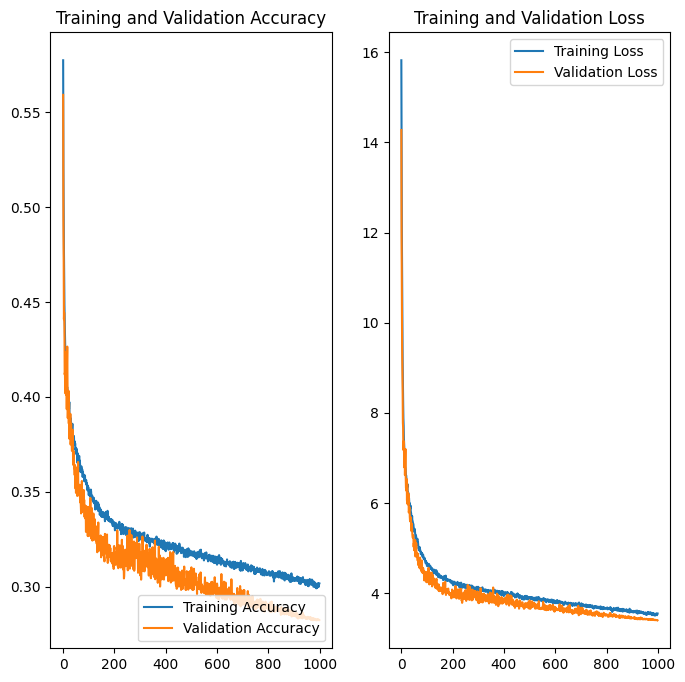

In [30]:
acc = history.history['mean_metric']
val_acc = history.history['val_mean_metric']

loss = history.history['loss']
val_loss = history.history['val_loss']

#epochs_range = range(val_epochs)
epochs_range = range(val_epochs)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

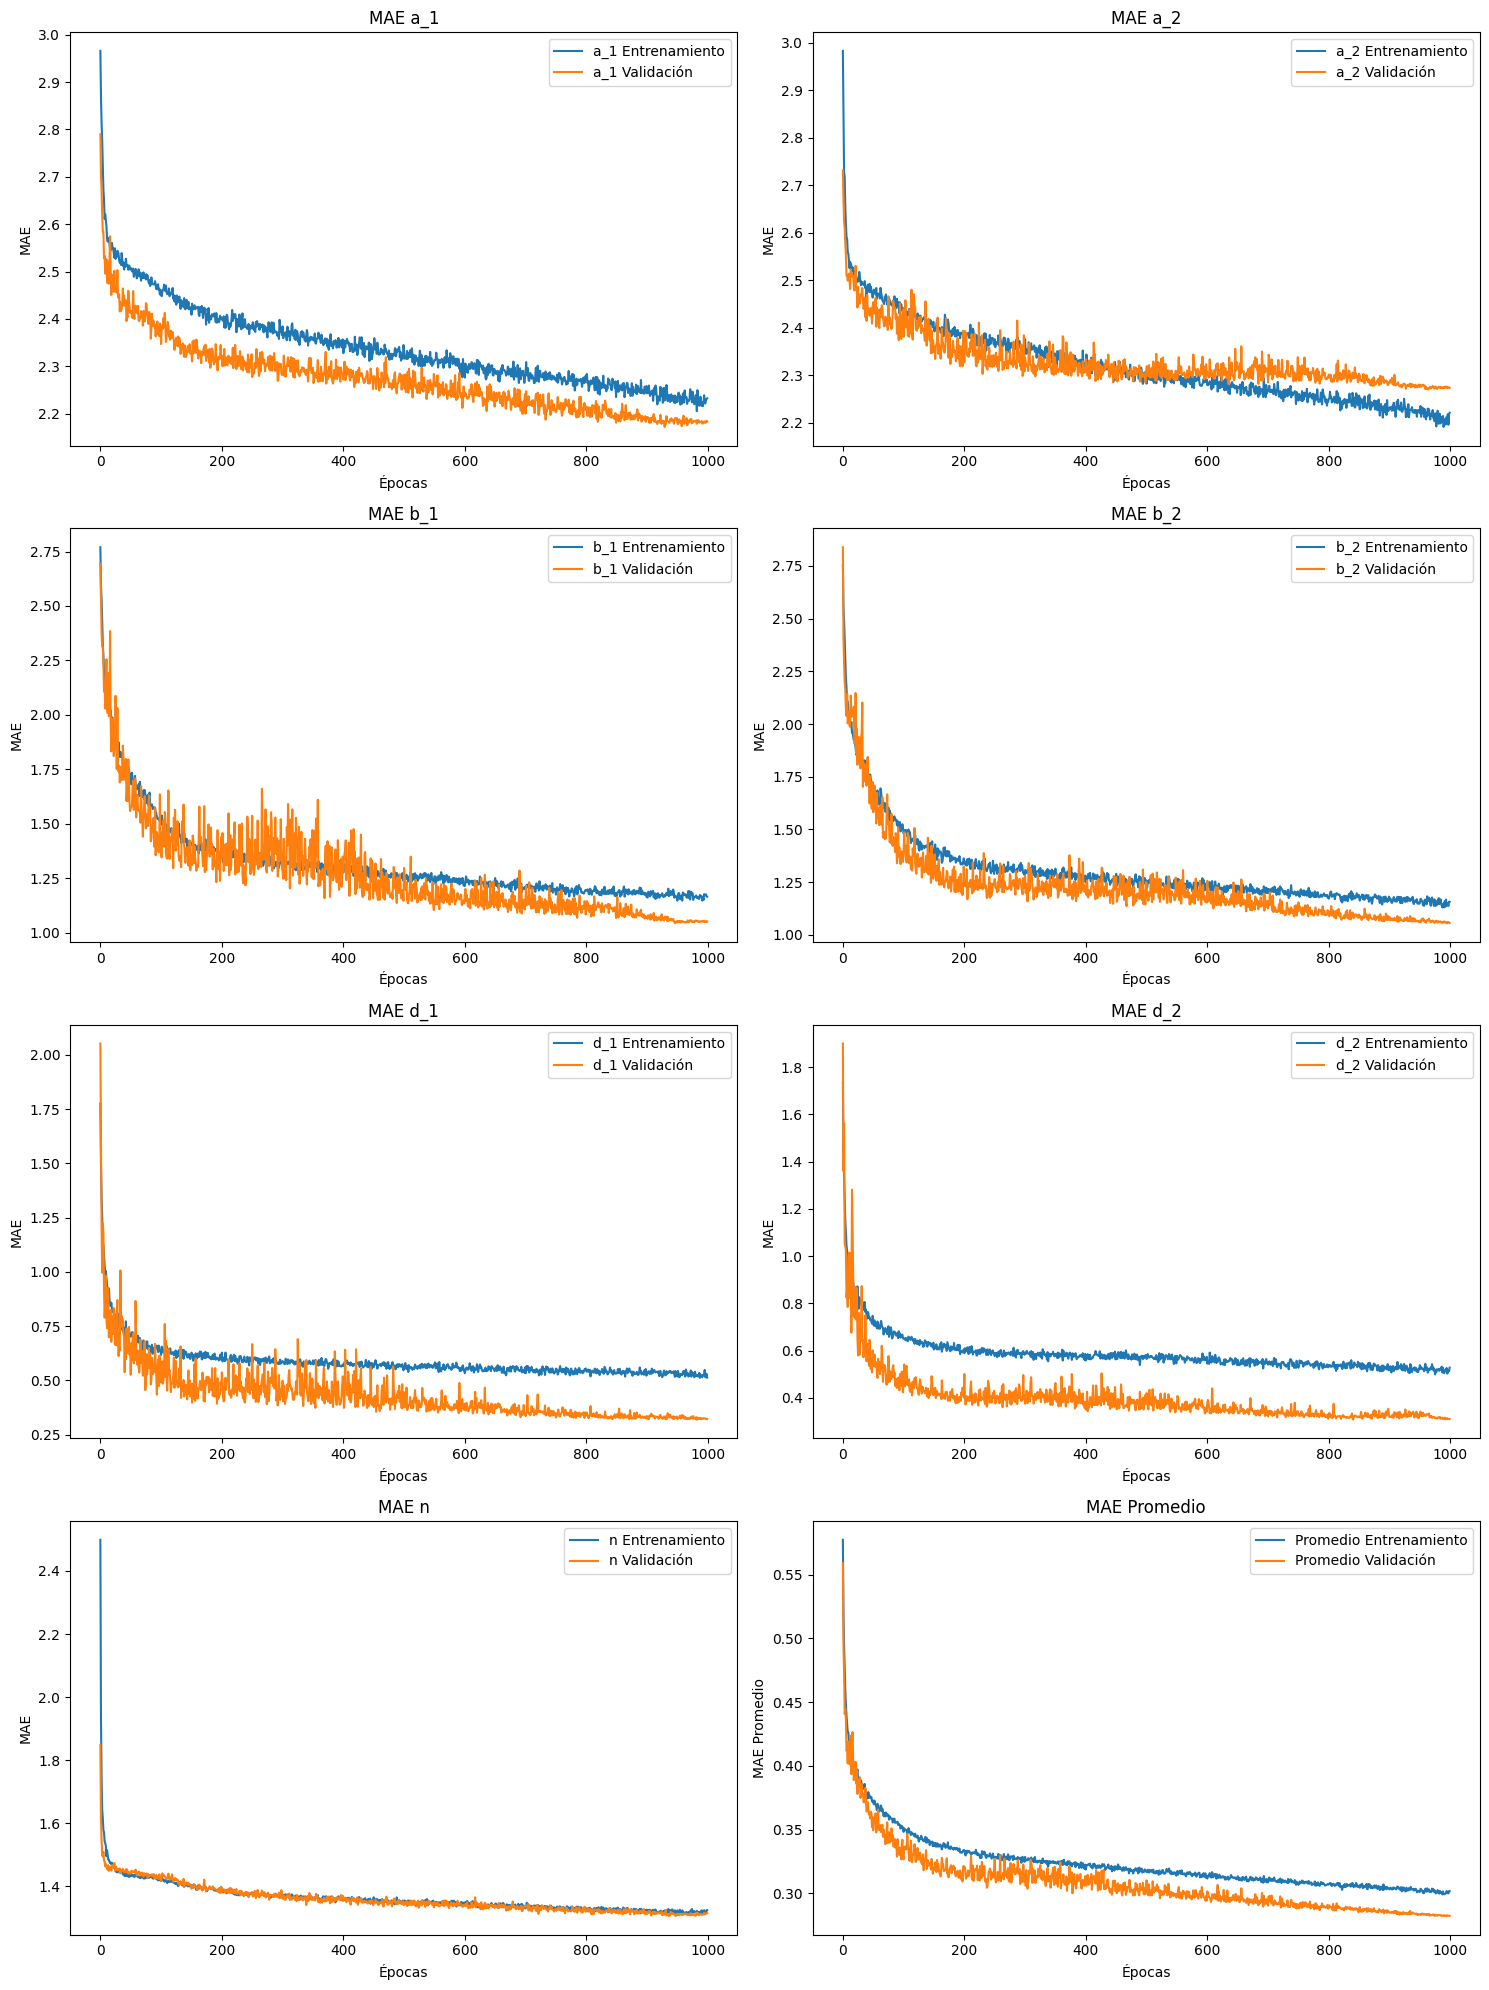

In [31]:
# Número de coeficientes más uno para la métrica adicional
n_coef = len(coeficientesnombres) + 1

# Número de filas y columnas para los subplots
n_rows = (n_coef + 1) // 2
n_cols = 2

# Crear una figura más grande para acomodar todos los subplots
plt.figure(figsize=(15, 5 * n_rows))

# Crear un subplot para cada coeficiente
for i, name in enumerate(coeficientesnombres):
    plt.subplot(n_rows, n_cols, i + 1)
    plt.plot(history.history[name ], label=name + ' Entrenamiento')
    plt.plot(history.history['val_' + name ], label=name + ' Validación')
    plt.title('MAE ' + name)
    plt.xlabel('Épocas')
    plt.ylabel('MAE')
    plt.legend()

# Agregar un subplot para la métrica prom_per
plt.subplot(n_rows, n_cols, n_coef)
plt.plot(history.history['mean_metric'], label='Promedio Entrenamiento')
plt.plot(history.history['val_mean_metric'], label='Promedio Validación')
plt.title('MAE Promedio')
plt.xlabel('Épocas')
plt.ylabel('MAE Promedio')
plt.legend()

# Ajustar el diseño para asegurarse de que todo encaje bien
plt.tight_layout()
plt.show()

# Evaluamos el modelo

In [32]:
test_loss, test_a1, test_a2, test_b1, test_b2, test_d1, test_d2, test_n, testprom_per = model.evaluate(
    varftest, coefvarftest)

32/32 [==============================] - 0s 903us/step - loss: 3.5147 - a_1: 2.2853 - a_2: 2.3151 - b_1: 1.0431 - b_2: 1.0611 - d_1: 0.3376 - d_2: 0.3010 - n: 1.3012 - mean_metric: 0.2871


In [33]:
predictions = model.predict(varftest)

32/32 [==============================] - 0s 774us/step


In [34]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Calcula el MAE
mae = mean_absolute_error(coefvarftest, predictions)

# Calcula la desviación estándar del error
error = coefvarftest - predictions
std_dev = np.std(error)

# Calcula el error absoluto máximo
max_error = np.max(np.abs(error))

print(f"MAE: {mae}, Desviación estándar del error: {std_dev}, Error absoluto máximo: {max_error}")

MAE: 1.2358399303931158, Desviación estándar del error: 1.7832586280194245, Error absoluto máximo: 7.475918769836426


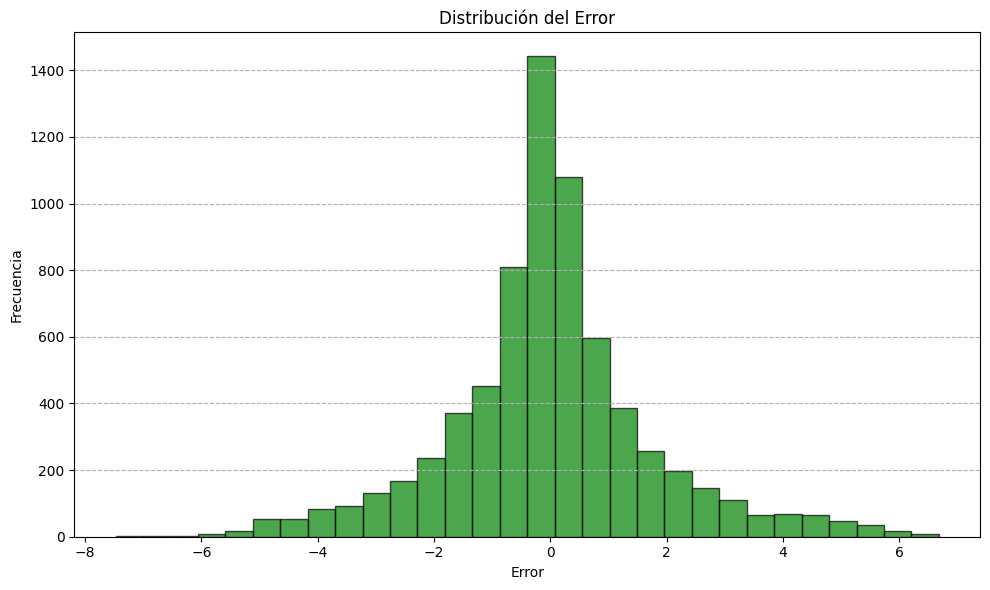

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(error.flatten(), bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error')  # Añade un título al gráfico
plt.xlabel('Error')  # Etiqueta el eje x
plt.ylabel('Frecuencia')  # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()

In [36]:
# Calcula el error absoluto para cada dato
absolute_error = np.abs(coefvarftest - predictions)

# Calcula el error para cada dato
error = coefvarftest - predictions

# Calcula la suma de los valores reales para cada dato
sum_real_values = np.sum(coefvarftest, axis=-1)

# Divide el error absoluto por la suma de los valores reales para cada dato
relative_error_per_data = np.sum(absolute_error, axis=-1) / sum_real_values

# Calcula el MAE relativo como la media de los errores relativos
relative_mae = np.mean(relative_error_per_data)

# Divide el error por la suma de los valores reales para cada dato
relative_error_per_data_std_max = np.sum(error, axis=-1) / sum_real_values

# Calcula la desviación estándar del error relativo
relative_std_dev = np.std(relative_error_per_data_std_max)

# Calcula el error absoluto máximo relativo
relative_max_error = np.max(np.abs(relative_error_per_data_std_max))

print(f"MAE relativo: {relative_mae}")
print(f"Desviación estándar del error relativo: {relative_std_dev}")
print(f"Error absoluto máximo relativo: {relative_max_error}")


MAE relativo: 0.28855426753025354
Desviación estándar del error relativo: 0.16220955929486183
Error absoluto máximo relativo: 1.5231348673502605


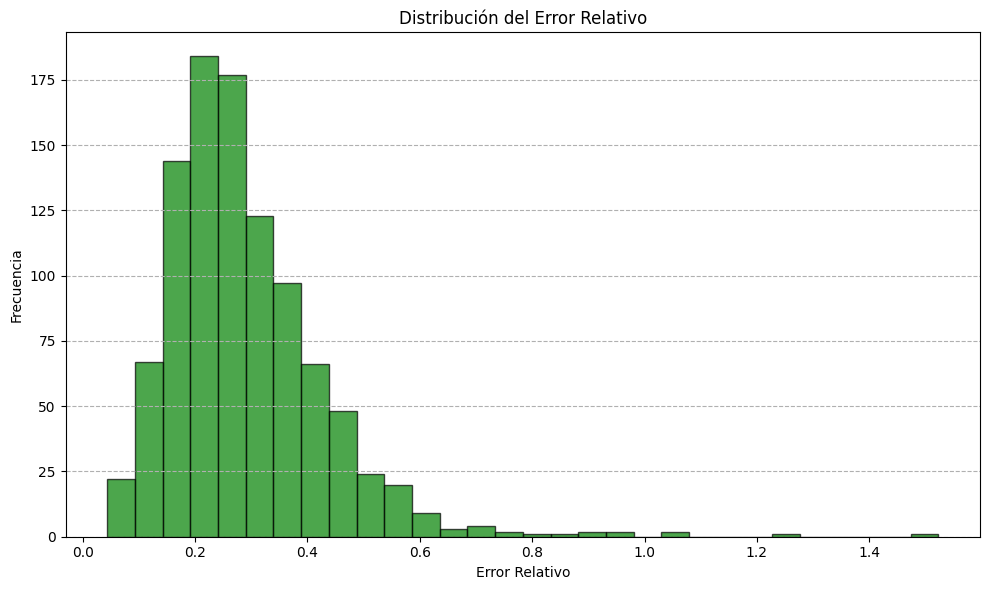

In [37]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Establece el tamaño del gráfico
plt.hist(relative_error_per_data, bins=30, edgecolor='black', alpha=0.7, color = 'green')  # Añade bordes negros a las barras y ajusta la transparencia
plt.title('Distribución del Error Relativo')  # Añade un título al gráfico
plt.xlabel('Error Relativo')  # Etiqueta el eje x
plt.ylabel('Frecuencia')      # Etiqueta el eje y
plt.grid(axis='y', linestyle='--')  # Añade una cuadrícula horizontal
plt.tight_layout()  # Ajusta el diseño para evitar que se recorten las etiquetas
plt.show()


# Guardamos los datos Accuracy y Loss

In [38]:
df = pd.DataFrame.from_dict(history.history)
df.to_csv('../../../Gráficas finales/History 50,100/historytrayec100.csv', index=False)

# Guardamos el modelo

In [39]:
path_to_save = '../../../Modelos/Modelos 50,100'

In [40]:
model.save(path_to_save + '/trayectorias100.h5')

# Importamos el modelo

In [41]:
def custom_activation(x):
    return 10 * tf.nn.sigmoid(x)

In [42]:
coeficientesnombres = ('a_1', 'a_2', 'b_1', 'b_2', 'd_1', 'd_2', 'n')

def mse_component(i):
    def mse_i(y_true, y_pred):
        return tf.keras.losses.mean_absolute_error(y_true[:, i], y_pred[:, i])

    mse_i.__name__ = coeficientesnombres[i]
    return mse_i

def mean_metric(y_true, y_pred):
    total_loss = 0
    for i in range(7):
        total_loss += mse_component(i)(y_true, y_pred)
    sum_of_true_coefficients = tf.reduce_sum(y_true, axis=-1)
    return total_loss / sum_of_true_coefficients

metrics = [mse_component(i) for i in range(7)] + [mean_metric]

In [43]:
import keras
import tensorflow as tf
# Creación de un diccionario con todas las métricas personalizadas
custom_objects = {'custom_activation':custom_activation,'mean_metric': mean_metric}
for i in range(7):
    custom_objects[coeficientesnombres[i]] = mse_component(i)
new_model = keras.models.load_model('../../../Modelos/Modelos 50,100/trayectorias100.h5', custom_objects=custom_objects)

# Probamos el modelo con datos nuevos

## Creamos nuevos datos

In [52]:
import random
from scipy.integrate import solve_ivp
condini = []
varf = []
coef = []
contador = 0
for i in range(0, 1):
    # constantes
    a1 = random.randint(0, 10)
    a2 = random.randint(0, 10)
    b1 = random.randint(0, 10)
    b2 = random.randint(0, 10)
    d1 = random.randint(0, 10)
    d2 = random.randint(0, 10)
    n = random.randint(0, 5)

    coef1 = [a1, a2, b1, b2, d1, d2, n]
    coef.append(coef1)

    def f(t, y):

        # asignar a cada ODE a un elemento de vector
        X = y[0]
        Y = y[1]

        # definimos cada ODE
        # dX_dt=a1/(1+Y**n)-d1*X+b1
        # dY_dt=a2/(1+X**n)-d2*Y+b2
        dX_dt = a1/(1+Y**n)-d1*X+b1
        dY_dt = a2/(1+X**n)-d2*Y+b1

        return [dX_dt, dY_dt]

    # Declaramos el vector de tiempo
    t_span = [0, 5]
    times = np.linspace(t_span[0], t_span[1], 100)
    
    varfci2 = []
    for i_ci in range(0, 10):
        # Definimos las condiciones iniciales
        y0 = np.array([random.randint(0, 10), random.randint(0, 10)])
        condini.append(y0)
        # Resolvemos
        # Modificar manualmente el intervalo de tiempo
        sol = solve_ivp(f, t_span, y0, t_eval=times)
        # sol=solve_ivp(f, t_span, y0) #Dejar que la librería elija el mejor intervalo
        tiempo = sol.t
        var1 = sol.y[0]
        var2 = sol.y[1]

        varfci = np.append([var1], [var2], axis=0)
        varfci2.append(varfci)

       

    varf= varfci2
    print('--------------------------------------------')
    print(coef1)
    print(np.shape(varf))
varf = np.array(varf)
coef = np.array(coef)

--------------------------------------------
[4, 4, 9, 2, 7, 6, 3]
(10, 2, 100)


In [53]:
varfnone = varf[None, :]

## Predecimos con los datos nuevos

In [54]:
new_predictions = new_model.predict(varfnone)
new_predictions = np.round(new_predictions)
new_predictions = np.clip(new_predictions, 0, None)
print(new_predictions)

1/1 [==============================] - 0s 11ms/step
[[5. 7. 8. 8. 7. 6. 3.]]


## Graficamos con los coeficientes reales

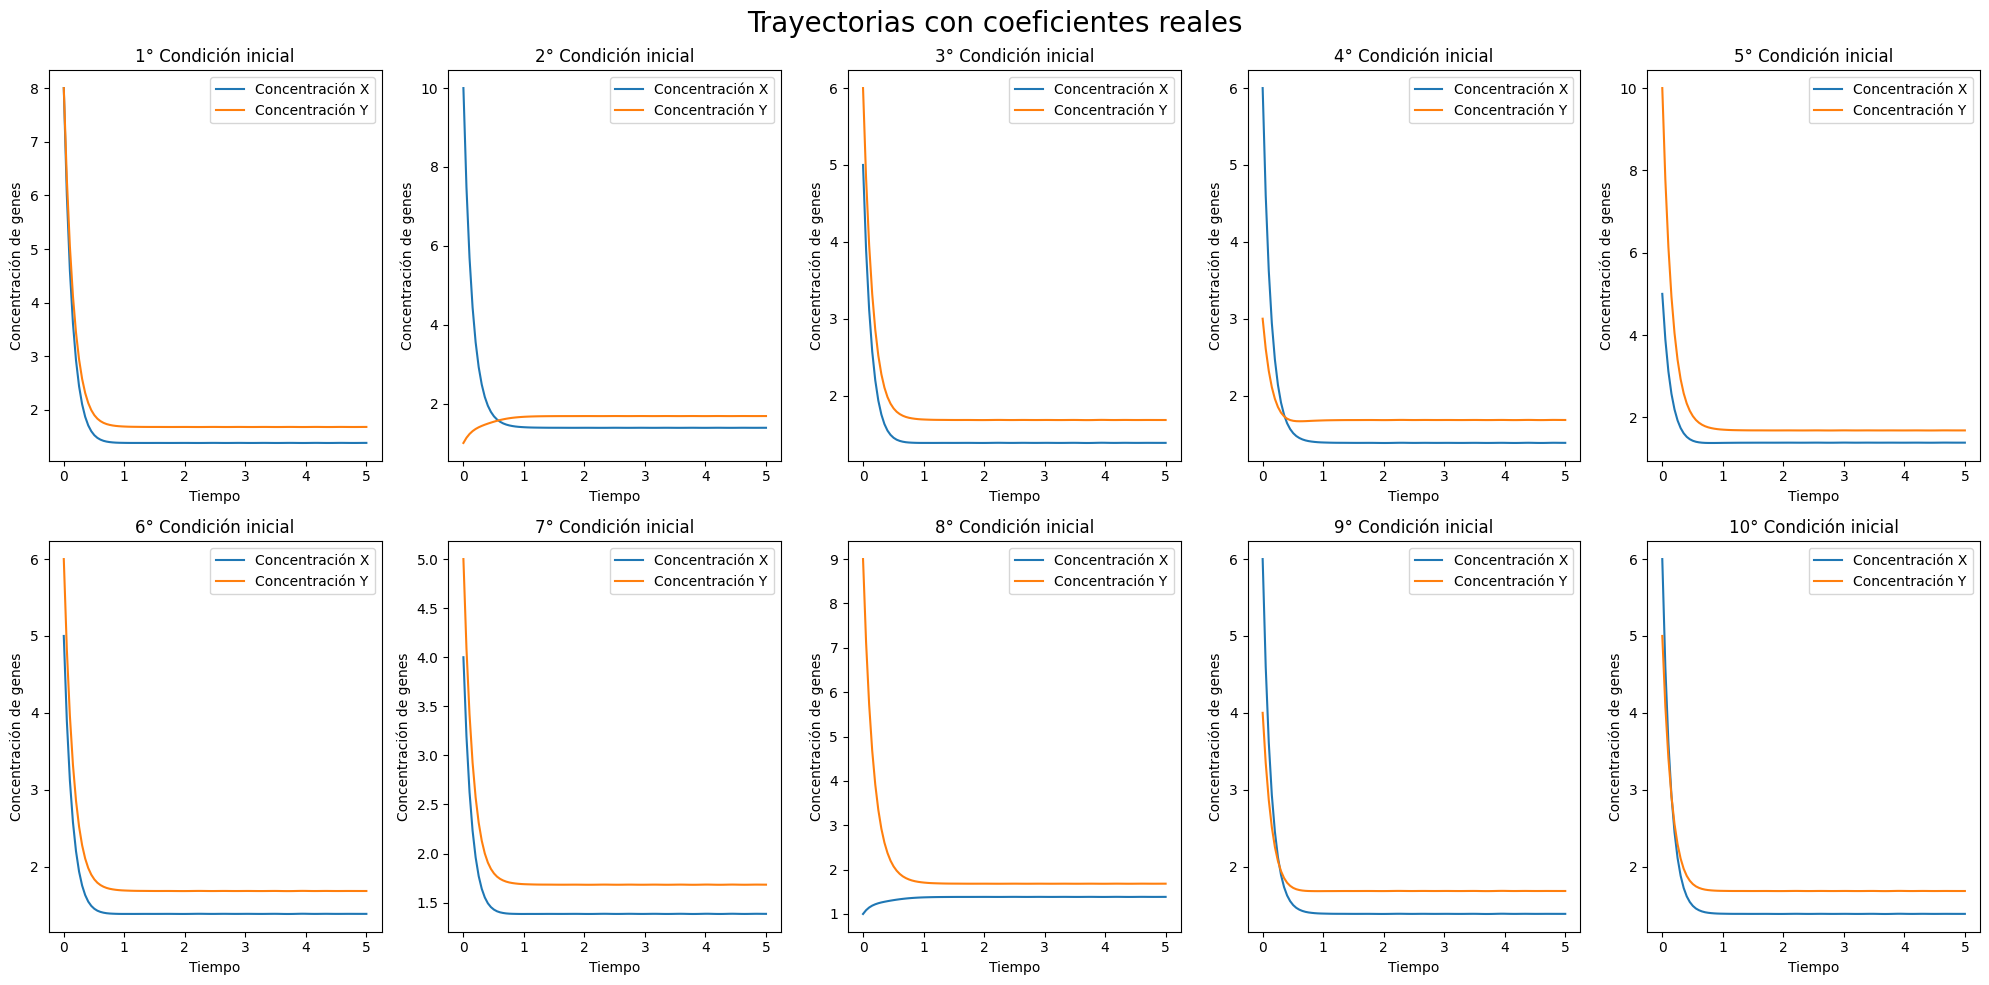

In [55]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes reales', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [56]:
np.shape(new_predictions)

(1, 7)

## Graficamos con los coeficientes predecidos

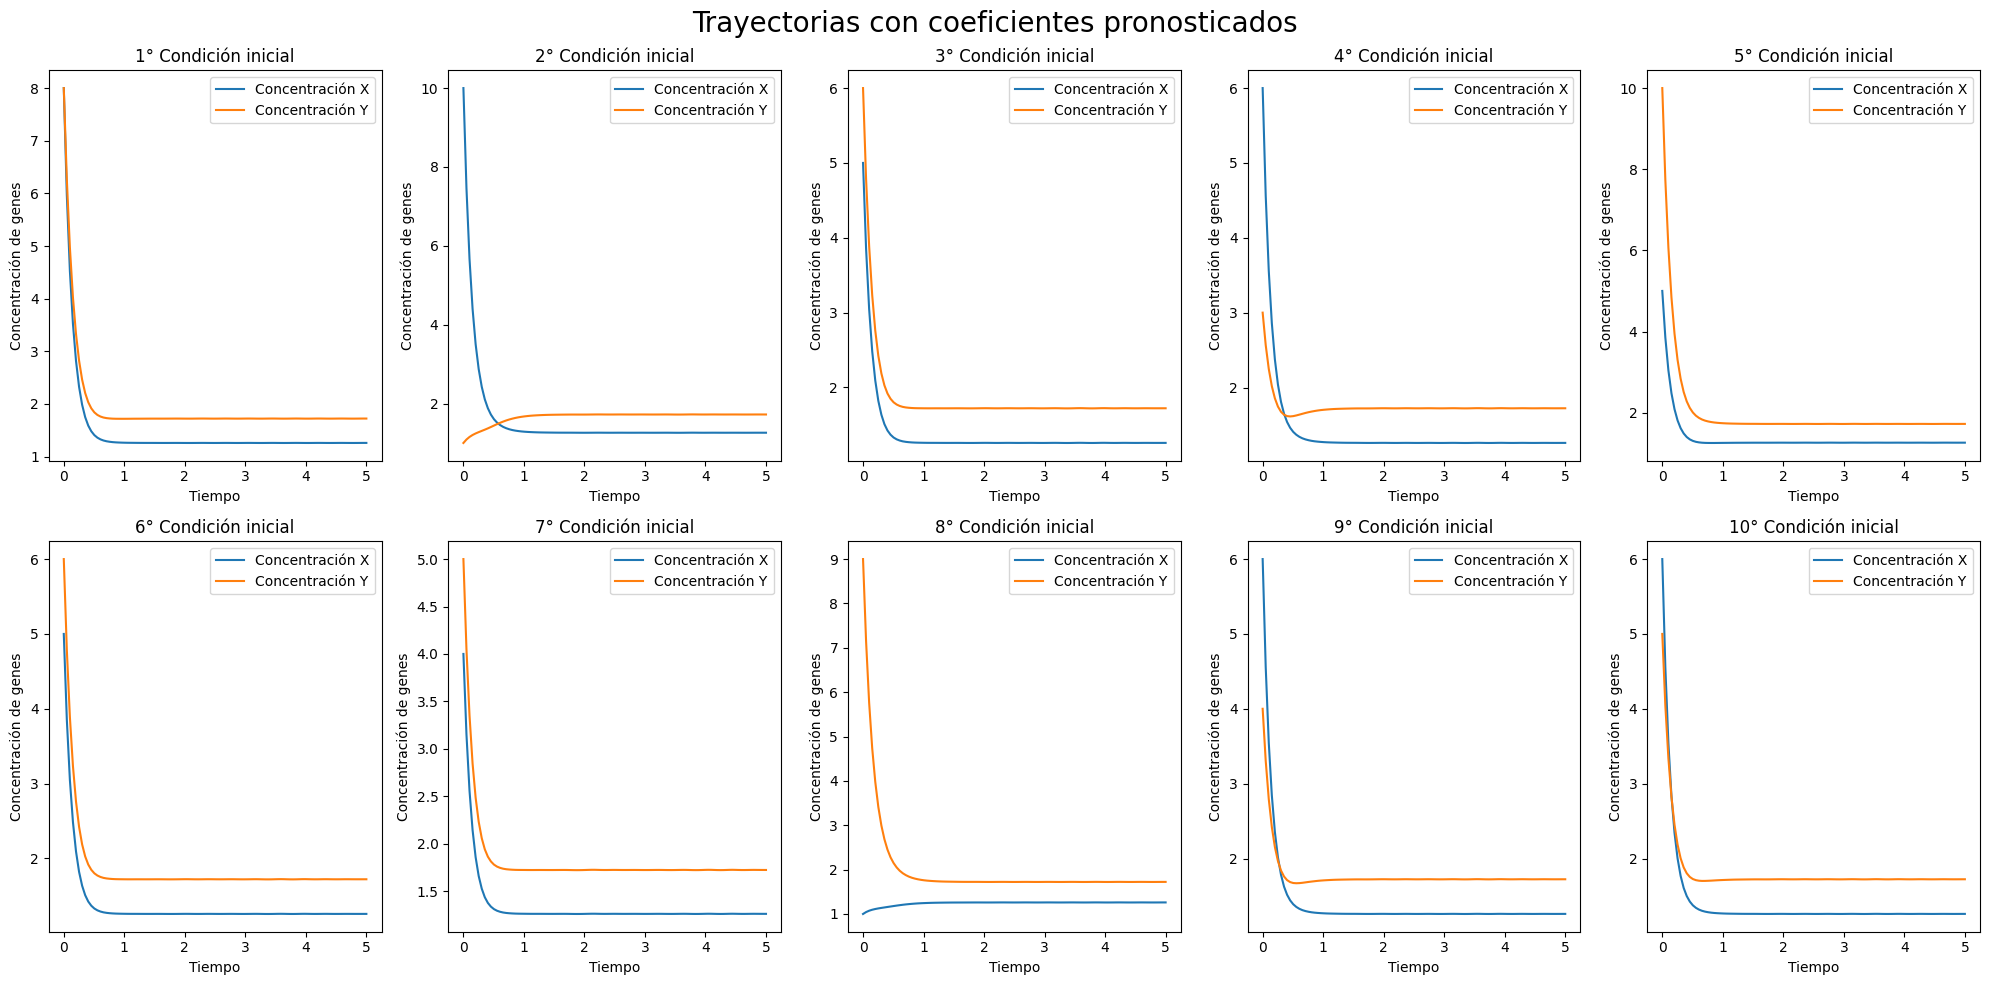

In [57]:
a1 = new_predictions[0,0]
a2 = new_predictions[0,1]
b1 = new_predictions[0,2]
b2 = new_predictions[0,3]
d1 = new_predictions[0,4]
d2 = new_predictions[0,5]
n = new_predictions[0,6]

varfpred = []

def f(t, y):

    # asignar a cada ODE a un elemento de vector
    X = y[0]
    Y = y[1]

    # definimos cada ODE
    dX_dt = a1/(1+Y**n)-d1*X+b1
    dY_dt = a2/(1+X**n)-d2*Y+b1

    return [dX_dt, dY_dt]

# Declaramos el vector de tiempo
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
varfci2pred = []

for i_ci in range(0, 10):
# Definimos las condiciones iniciales
    y0 = condini[i_ci]
    # Resolvemos
    sol = solve_ivp(f, t_span, y0, t_eval=times)
    tiempo = sol.t
    var1pred = sol.y[0]
    var2pred = sol.y[1]
    varfcipred = np.append([var1pred], [var2pred], axis=0)
    varfci2pred.append(varfcipred)
    
varfpred= varfci2pred

fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 5 filas de gráficos, 2 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos
# Graficamos
for i in range(10):
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X")
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y")
    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Trayectorias con coeficientes pronosticados', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  
plt.show()

## Graficamos ambos

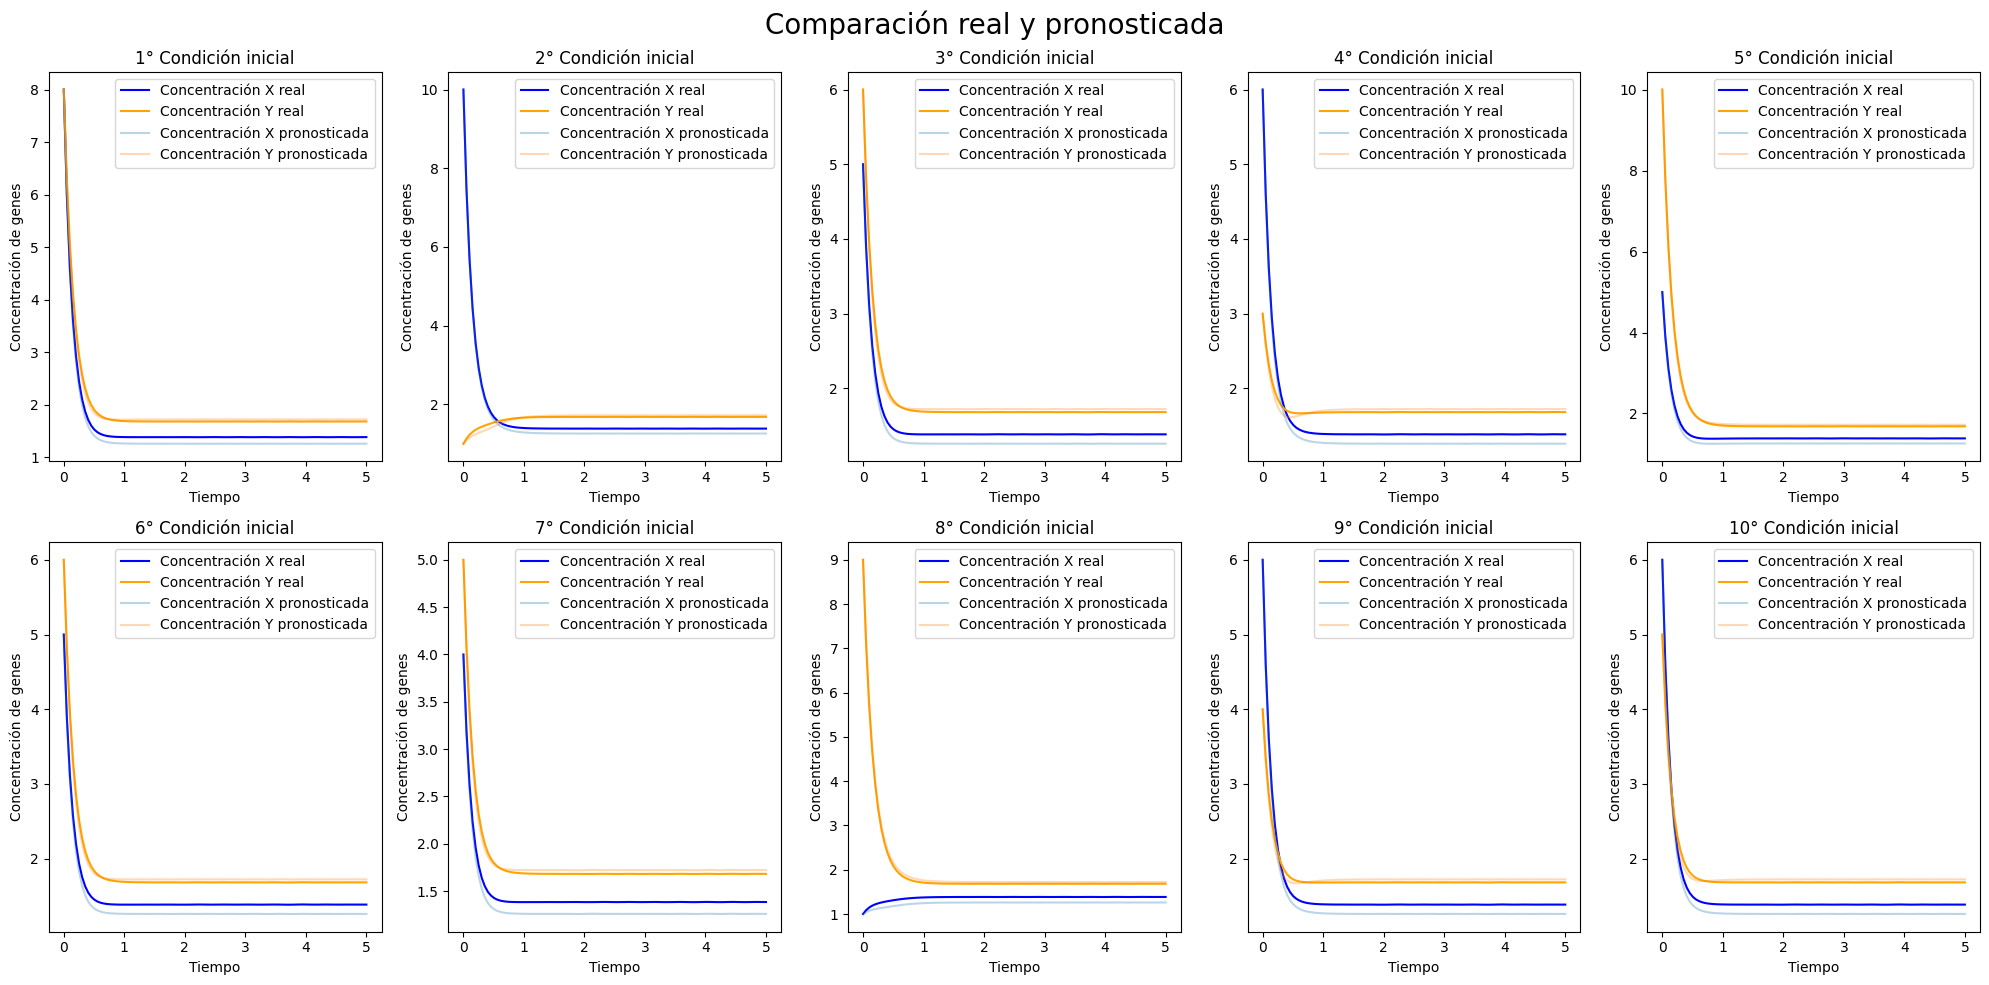

In [58]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

for i in range(10):
    # varf
    axes[i].plot(times, np.array(varf)[i, 0, :], label=f"Concentración X real", alpha=1, color = 'blue')
    axes[i].plot(times,np.array(varf)[i,1,:], label=f"Concentración Y real", alpha=1, color = 'orange')

    # varfpred
    axes[i].plot(times, np.array(varfpred)[i, 0, :], label=f"Concentración X pronosticada", alpha=0.3)
    axes[i].plot(times,np.array(varfpred)[i,1,:], label=f"Concentración Y pronosticada", alpha=0.3)

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

## Graficamos las diferencias

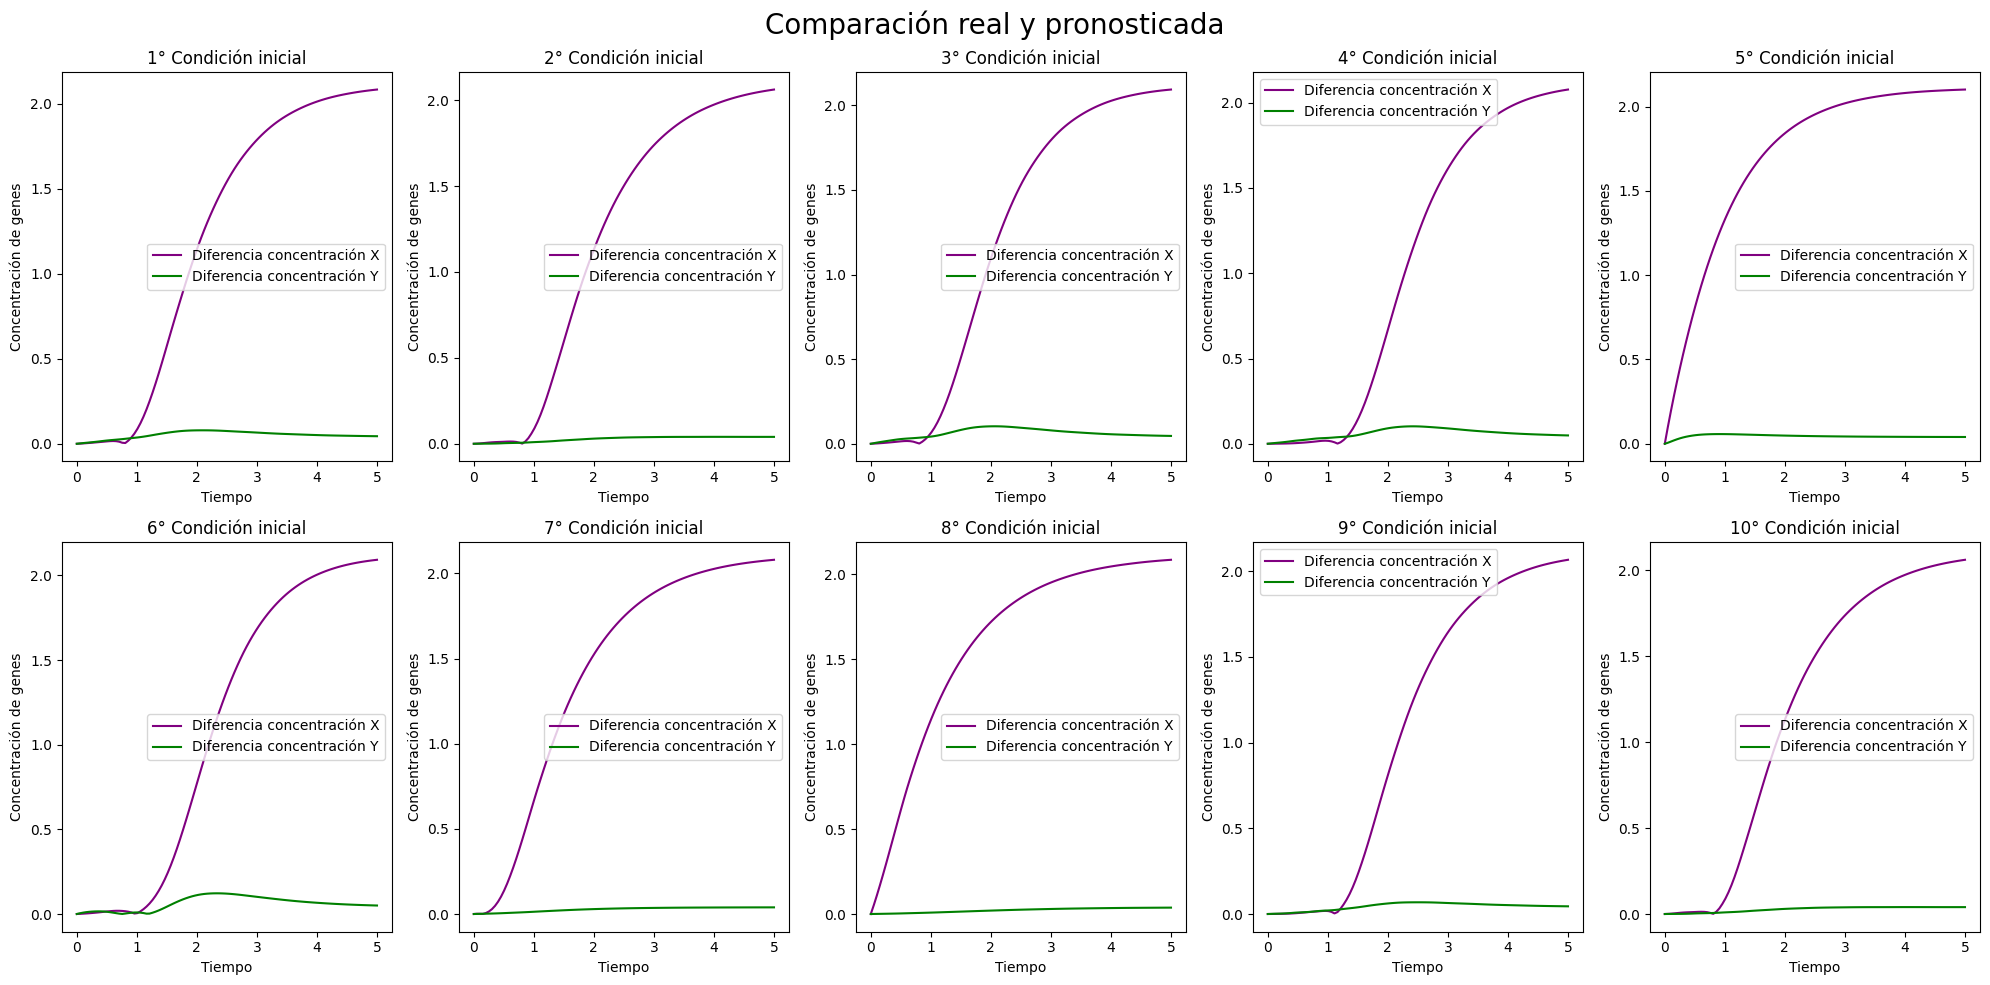

In [51]:
t_span = [0, 5]
times = np.linspace(t_span[0], t_span[1], 100)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))  # 2 filas de gráficos, 5 columnas
axes = axes.ravel()  # esto convierte la matriz de ejes en un array plano, para poder iterar sobre ellos

sum_errors_X = []
sum_errors_Y = []
for i in range(10):
    # Diferencia
    diff_X = np.abs(np.array(varf)[i, 0, :] - np.array(varfpred)[i, 0, :])
    diff_Y = np.abs(np.array(varf)[i, 1, :] - np.array(varfpred)[i, 1, :])
    axes[i].plot(times, diff_X, label=f"Diferencia concentración X", alpha=1, color = "purple")
    axes[i].plot(times, diff_Y, label=f"Diferencia concentración Y", alpha=1, color = "g")
    # Suma de los errores
    sum_errors_X.append(np.sum(np.abs(diff_X)))
    sum_errors_Y.append(np.sum(np.abs(diff_Y)))

    axes[i].set_xlabel('Tiempo')
    axes[i].set_ylabel('Concentración de genes')
    axes[i].legend()
    axes[i].set_title(f'{i+1}° Condición inicial')

fig.suptitle('Comparación real y pronosticada', fontsize=20)  # Título general para todas las subfiguras

plt.tight_layout()  # esto ayuda a que los gráficos no se superpongan
plt.show()

In [58]:
print(np.sum(sum_errors_X)/2000)
print(np.sum(sum_errors_Y)/2000)

0.048441966872410105
0.14085278985955624
